In [36]:
import os
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

## ----- Imports -----
from utils import *
from modules import RNNModel, SeqDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F


DATETIME_STAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
new_dir_path = get_next_versioned_directory('rnn_training')
print(f"Created new directory: {new_dir_path}")

print(torch.__version__)
print(f"MPS available: {torch.backends.mps.is_available()}")

if torch.backends.mps.is_available():
    device = torch.device("mps")
    device_type = "mps"
    x = torch.ones(1, device=device)
    print(x)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    device_type = "cuda"
    print("CUDA device found.")
else:
    print ("Using CPU.")
    device_type = "cpu"
    device = torch.device("cpu")

SEED = 42
set_seed(SEED)

# Usage: call once before training
log_file = setup_logging(new_dir_path)
logging.info(f'Seed: {SEED}')

NUM_EPOCHS = 30
SNIPPET_LENGTH = 50
SNIPPET_OVERLAP = False
NUM_LAYERS = 1  # Number of GRU layers

# pairs of (config, roi) that are known to have good responses
good_pairs = [(3,26),(3,22),(7,31),(8,26),(8,31),(9,26),(9,27),(9,31),(11,26),
              (12,26),(13,22),(14,22),(14,23),
              (15,22),(15,23),(23,21),(24,21),(26,31),(27,31),(28,26),(28,31),
              (29,26),(29,31),(30,26),(30,27),(30,31)]

# ==================== DATA FILTERING OPTIONS ====================
# Set to None to use all, or provide a list to filter

# Filter by configs (1-31). Set to None for all configs, or e.g., [1, 2, 3] for specific ones
FILTER_CONFIGS = None  # e.g., list(range(1, 11)) for configs 1-10, or [3, 7, 15]

# Filter by neurons/ROIs (1-indexed). Set to None for all neurons, or provide a list
# You can use good_pairs to extract neurons: [n for c, n in good_pairs]
# These neurons are used for initial conditions AND as the pool for targets
FILTER_NEURONS = None  # e.g., [21, 22, 23, 26, 27, 31] for specific neurons

# Target neurons to predict (1-indexed). Must be a subset of FILTER_NEURONS.
# Set to None to predict all FILTER_NEURONS, or provide a list for specific neurons
TARGET_NEURONS = [pair[1] for pair in good_pairs]  # e.g., [31] to only predict neuron 31

# Filter by electrodes (0-9). Set to None for all electrodes
FILTER_ELECTRODES = None  # e.g., [0, 1, 2] for first 3 electrodes

# Filter by current levels (3, 4, 5). Set to None for all currents
FILTER_CURRENTS = None  # e.g., [5] for highest current only

# ================================================================

logging.info(f'Number of epochs {NUM_EPOCHS}')
checkpoint_filepath = os.path.join("rnn_training", DATETIME_STAMP, "best_model.pth")


data = scipy.io.loadmat('data.mat')
times = np.stack(data['times'][0, ...])
dfof = np.stack(data['dfof'][0, ...])
configs = np.stack( data['configs'][0, ...])
roi_used = data['roi_used']



# If filtering neurons, subset the dfof data to only include those neurons
if FILTER_NEURONS is not None:
    neuron_indices = [n - 1 for n in FILTER_NEURONS]  # Convert to 0-indexed
    dfof = np.array([session_dfof[:, neuron_indices] for session_dfof in dfof])
    logging.info(f"Filtered to {len(FILTER_NEURONS)} neurons: {FILTER_NEURONS}")
    logging.info(f"New dfof shape: {dfof.shape}")

# Validate and compute TARGET_NEURONS indices
# TARGET_NEURONS are the neurons to predict; must be subset of FILTER_NEURONS
if TARGET_NEURONS is None:
    # Default: predict all filtered neurons
    TARGET_NEURONS = FILTER_NEURONS if FILTER_NEURONS is not None else list(range(1, dfof[0].shape[1] + 1))
    target_indices = None  # Use all columns
else:
    # Validate that TARGET_NEURONS is a subset of FILTER_NEURONS
    if FILTER_NEURONS is not None:
        invalid_targets = set(TARGET_NEURONS) - set(FILTER_NEURONS)
        if invalid_targets:
            raise ValueError(f"TARGET_NEURONS {invalid_targets} not in FILTER_NEURONS {FILTER_NEURONS}")
        # Compute indices relative to filtered dfof
        target_indices = [FILTER_NEURONS.index(n) for n in TARGET_NEURONS]
    else:
        # No filtering, use original neuron indices (0-indexed)
        target_indices = [n - 1 for n in TARGET_NEURONS]
    logging.info(f"Target neurons: {TARGET_NEURONS}")
    logging.info(f"Target indices in filtered data: {target_indices}")

logging.info(f"configs shape: {configs.shape}")
logging.info(f"roi_used shape: {roi_used.shape}")
logging.info(f"times shape: {times.shape}")
logging.info(f"dfof shape: {dfof.shape}")

# Configs is a (n_sessions, n_rois, n_configs) array
# Times is a (n_sessions, n_trials, n_configs) array. They don't have to be serial (i.e. Channel X can be stimulated twice before Channel Y is stimulated once)
# Roi_used is a (512, 512) binary mask of which ROIs were used in the experiment
# dfof is a (n_sessions, n_timepoints, n_rois) array
# note that the sampling frequency of dfof is 30 Hz, so 30 frames is ~ 1 second of activity

Created new directory: rnn_training/20260107_145843
2.10.0.dev20251124
MPS available: True
tensor([1.], device='mps:0')
Random seed set as 42
2026-01-07 14:58:43,154 INFO: Logging started. Output file: rnn_training/20260107_145843/console.log
2026-01-07 14:58:43,154 INFO: Seed: 42
2026-01-07 14:58:43,154 INFO: Number of epochs 30
2026-01-07 14:58:43,348 INFO: Target neurons: [26, 22, 31, 26, 31, 26, 27, 31, 26, 26, 22, 22, 23, 22, 23, 21, 21, 31, 31, 26, 31, 26, 31, 26, 27, 31]
2026-01-07 14:58:43,348 INFO: Target indices in filtered data: [25, 21, 30, 25, 30, 25, 26, 30, 25, 25, 21, 21, 22, 21, 22, 20, 20, 30, 30, 25, 30, 25, 30, 25, 26, 30]
2026-01-07 14:58:43,349 INFO: configs shape: (3, 110, 31)
2026-01-07 14:58:43,349 INFO: roi_used shape: (512, 512)
2026-01-07 14:58:43,350 INFO: times shape: (3, 8, 31)
2026-01-07 14:58:43,350 INFO: dfof shape: (3, 15600, 110)


In [69]:
# Create a DataFrame for easy data querying by session, trial, config, electrode, current
import pandas as pd

# START_OFFSET: how many frames before trial_start_time the snippet should begin
# If START_OFFSET=0, snippet starts at trial_start_time
# If START_OFFSET=10, snippet starts 10 frames BEFORE trial_start_time
# If START_OFFSET=-5, snippet starts 5 frames AFTER trial_start_time
START_OFFSET = 0  # frames before trial_start_time that snippet begins

# STIM_DELAY: how many frames after trial_start_time the stimulation occurs
# If STIM_DELAY=0, stim occurs at trial_start_time
# If STIM_DELAY=10, stim occurs 10 frames after trial_start_time
STIM_DELAY = 10  # frames after trial_start_time when stim occurs

logging.info(f"Creating trials DataFrame with START_OFFSET={START_OFFSET} (snippet starts {START_OFFSET} frames before trial_start_time)")
logging.info(f"Creating trials DataFrame with STIM_DELAY={STIM_DELAY} (stim occurs {STIM_DELAY} frames after trial_start_time)")

rows = []
for session in range(3):
    # Add stimulation trials (configs 1-30)
    for config in range(1, 31):
        electrode = (config - 1) // 3
        current = (config - 1) % 3 + 3  # 3, 4, or 5
        for trial in range(8):
            # trial_start_time: when the trial begins (from times array)
            trial_start_time = int(times[session][trial, config - 1])
            # stim_time: when stim occurs (STIM_DELAY frames after trial_start_time)
            stim_time = trial_start_time + STIM_DELAY
            # start_time: when snippet starts (START_OFFSET frames before trial_start_time)
            start_time = max(trial_start_time - START_OFFSET, 0)
            rows.append({
                'session': session,
                'trial': trial,
                'config': config,
                'electrode': electrode,
                'current': current,
                'trial_start_time': trial_start_time,  # when trial begins
                'stim_time': stim_time,  # when stim occurs
                'start_time': int(start_time),  # snippet start time
                'is_stim': True
            })
    
    # Add no-stim trials (config 31)
    for trial in range(8):
        trial_start_time = int(times[session][trial, 30])  # config 31 is index 30
        stim_time = trial_start_time  # no actual stim, but use same timing
        start_time = max(trial_start_time - START_OFFSET, 0)
        rows.append({
            'session': session,
            'trial': trial,
            'config': 31,
            'electrode': -1,  # no electrode for no-stim
            'current': 0,
            'trial_start_time': trial_start_time,
            'stim_time': stim_time,
            'start_time': int(start_time),
            'is_stim': False
        })

trials_df = pd.DataFrame(rows)
logging.info(f"Total trials before filtering: {len(trials_df)}")

# Apply config filter
if FILTER_CONFIGS is not None:
    trials_df = trials_df[trials_df['config'].isin(FILTER_CONFIGS)]
    logging.info(f"Filtered to configs {FILTER_CONFIGS}: {len(trials_df)} trials remaining")

# Apply electrode filter  
if FILTER_ELECTRODES is not None:
    # Keep no-stim trials (electrode=-1) and trials with matching electrodes
    trials_df = trials_df[(trials_df['electrode'].isin(FILTER_ELECTRODES)) | (trials_df['electrode'] == -1)]
    logging.info(f"Filtered to electrodes {FILTER_ELECTRODES}: {len(trials_df)} trials remaining")

# Apply current filter
if FILTER_CURRENTS is not None:
    # Keep no-stim trials (current=0) and trials with matching currents
    trials_df = trials_df[(trials_df['current'].isin(FILTER_CURRENTS)) | (trials_df['current'] == 0)]
    logging.info(f"Filtered to currents {FILTER_CURRENTS}: {len(trials_df)} trials remaining")

logging.info(f"Final trials_df size: {len(trials_df)}")

# Add activity data reference - get the dfof snippet around each stim time
def get_activity_snippet(row, snippet_length=SNIPPET_LENGTH):
    """Get activity snippet starting at start_time"""
    session = row['session']
    t = row['start_time']
    if t + snippet_length <= dfof[session].shape[0]:
        return dfof[session][t:t + snippet_length, :]
    return None

# Display summary
logging.info(f"DataFrame shape: {trials_df.shape}")
logging.info(f"Trials per session: {trials_df.groupby('session').size().to_dict()}")
logging.info(f"Unique values:")
logging.info(f"  Sessions: {', '.join(map(str, sorted(trials_df['session'].unique())))}")
logging.info(f"  Configs: {', '.join(map(str, sorted(trials_df['config'].unique())))}")
logging.info(f"  Electrodes: {', '.join(map(str, sorted(trials_df['electrode'].unique())))}")
logging.info(f"  Currents: {', '.join(map(str, sorted(trials_df['current'].unique())))}")

# Log filter status
logging.info(f"--- Filter Status ---")
logging.info(f"  FILTER_CONFIGS: {FILTER_CONFIGS if FILTER_CONFIGS else 'All'}")
logging.info(f"  FILTER_NEURONS: {FILTER_NEURONS if FILTER_NEURONS else 'All'}")
logging.info(f"  FILTER_ELECTRODES: {FILTER_ELECTRODES if FILTER_ELECTRODES else 'All'}")
logging.info(f"  FILTER_CURRENTS: {FILTER_CURRENTS if FILTER_CURRENTS else 'All'}")

logging.info(f"trials_df head:\n{trials_df.head(10)}")
logging.info(f"--- Example queries ---")
logging.info(f"Electrode 9, Current 5: {len(trials_df[(trials_df['electrode'] == 9) & (trials_df['current'] == 5)])} trials")
logging.info(f"Session 0, Config 7: {len(trials_df[(trials_df['session'] == 0) & (trials_df['config'] == 7)])} trials")

2026-01-07 17:20:20,088 INFO: Creating trials DataFrame with START_OFFSET=0 (snippet starts 0 frames before trial_start_time)
2026-01-07 17:20:20,089 INFO: Creating trials DataFrame with STIM_DELAY=10 (stim occurs 10 frames after trial_start_time)
2026-01-07 17:20:20,099 INFO: Total trials before filtering: 744
2026-01-07 17:20:20,100 INFO: Final trials_df size: 744
2026-01-07 17:20:20,100 INFO: DataFrame shape: (744, 9)
2026-01-07 17:20:20,105 INFO: Trials per session: {0: 248, 1: 248, 2: 248}
2026-01-07 17:20:20,106 INFO: Unique values:
2026-01-07 17:20:20,107 INFO:   Sessions: 0, 1, 2
2026-01-07 17:20:20,108 INFO:   Configs: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31
2026-01-07 17:20:20,108 INFO:   Electrodes: -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
2026-01-07 17:20:20,109 INFO:   Currents: 0, 3, 4, 5
2026-01-07 17:20:20,109 INFO: --- Filter Status ---
2026-01-07 17:20:20,110 INFO:   FILTER_CONFIGS: All
2026-01-07 17:20

This data contains single-electrode stims @ 3 current levels over 10 possible electrodes = 30 combinations + no-stim =  31 configurations total,Each configuration repeated 8 times in each of the
3 sessions. 2P imaging occurs at 30Hz per neuron.

In [70]:
# ----- Create snippets DataFrame and split data -----
from utils import make_snippets_df, snippets_df_to_arrays
from sklearn.model_selection import train_test_split

# Create snippets DataFrame from trials_df
# Stimulation timing is derived from trials_df['stim_time'] = trial_start_time + STIM_DELAY
# overlap=True creates overlapping snippets (like original make_snippets), giving ~46k+ snippets
# overlap=False only creates snippets aligned to trial stim times (~744 snippets)
# stride controls step size for overlapping snippets (1=full overlap, length=non-overlapping)
SNIPPET_STRIDE = 1  # Set to SNIPPET_LENGTH for non-overlapping

snippets_df = make_snippets_df(trials_df, dfof, SNIPPET_LENGTH, 
                                overlap=SNIPPET_OVERLAP, stride=SNIPPET_STRIDE)

logging.info(f"Snippets DataFrame shape: {snippets_df.shape}")
logging.info(f"Valid snippets: {snippets_df['valid'].sum()}")
logging.info(f"Snippets with stim at t=0: {snippets_df['stim_at_t0'].sum()}")

# ==================== SPLIT STRATEGY ====================
# Choose one of: 'random', 'session', 'trial', 'config', 'electrode', 'current', 'stim_at_t0'
SPLIT_STRATEGY = 'trial'

# For 'session': which sessions to hold out for test (only valid if SPLIT_STRATEGY=='session')
HOLDOUT_SESSIONS = []  # e.g., session 2 as test

# For 'trial': which trial indices to hold out (only valid if SPLIT_STRATEGY=='trial')
HOLDOUT_TRIALS = [7]  # e.g., trials 1 and 7 as test (0-indexed, range 0-7)

# For 'config': which configs to hold out (only valid if SPLIT_STRATEGY=='config')
HOLDOUT_CONFIGS = []  # e.g., configs 28-30 as test

# For 'electrode': which electrodes to hold out (only valid if SPLIT_STRATEGY=='electrode')
HOLDOUT_ELECTRODES = []  # e.g., electrode 9 as test

# For 'current': which current levels to hold out (only valid if SPLIT_STRATEGY=='current')
HOLDOUT_CURRENTS = []  # e.g., highest current as test

# ========================================================

valid_df = snippets_df[snippets_df['valid']].copy()
# Random split proportions if using random SPLIT_STRATEGY
VAL_SIZE = 0.15 
TEST_SIZE = 0.15

# Helper function to find snippets near specific stim times
def get_stim_times_for_holdout(trials_df, holdout_values, holdout_column, sessions):
    """Get stim times for holdout trials/configs/etc, grouped by session"""
    holdout_stims = trials_df[trials_df[holdout_column].isin(holdout_values)]
    stim_times_by_session = {}
    for session in sessions:
        # Use stim_time (actual stim time) for temporal matching
        session_stims = holdout_stims[holdout_stims['session'] == session]['stim_time'].values
        stim_times_by_session[session] = set(session_stims)
    return stim_times_by_session

def find_snippets_near_stim_times(source_df, stim_times_by_session, snippet_length):
    """
    Find indices in source_df whose frames overlap with or are within snippet_length of stim times.
    A snippet [start, start+L) is matched if any of its frames overlaps with the window around a stim time.
    """
    matching_indices = set()
    
    for idx, row in source_df.iterrows():
        session = row['session']
        snippet_start = row['snippet_start']
        snippet_end = snippet_start + snippet_length
        
        if session not in stim_times_by_session:
            continue
            
        # Check if this snippet's time window overlaps with any holdout stim time window
        for stim_time in stim_times_by_session[session]:
            # Stim window is [stim_time - L, stim_time + L)
            # Snippet window is [snippet_start, snippet_end)
            # They overlap if: snippet_start < stim_time + L AND snippet_end > stim_time - L
            if snippet_start < stim_time + snippet_length and snippet_end > stim_time - snippet_length:
                matching_indices.add(idx)
                break
    
    return matching_indices

def find_overlapping_snippets(source_df, test_df, snippet_length):
    """
    Find indices in source_df that share ANY frames with test_df snippets.
    This ensures complete temporal separation between train/val and test.
    
    A snippet overlaps if any of its frames (including initial condition at snippet_start-1)
    overlaps with any test snippet frames (including their initial conditions).
    """
    overlapping_indices = set()
    
    # Build set of frames used by test snippets (including initial condition frame)
    test_frames_by_session = {}
    for _, row in test_df.iterrows():
        session = row['session']
        if session not in test_frames_by_session:
            test_frames_by_session[session] = set()
        # Include all frames in snippet AND the initial condition frame (snippet_start - 1)
        start = row['snippet_start']
        init_cond_frame = max(0, start - 1)
        test_frames_by_session[session].update(range(init_cond_frame, start + snippet_length))
    
    for idx, row in source_df.iterrows():
        session = row['session']
        if session not in test_frames_by_session:
            continue
        
        snippet_start = row['snippet_start']
        init_cond_frame = max(0, snippet_start - 1)
        # Check if any frame in this snippet (including init cond) overlaps with test frames
        snippet_frames = set(range(init_cond_frame, snippet_start + snippet_length))
        if snippet_frames & test_frames_by_session[session]:
            overlapping_indices.add(idx)
    
    return overlapping_indices

# Get sessions
sessions = sorted(valid_df['session'].unique())

if SPLIT_STRATEGY == 'random':
    # Completely random split
    train_val_df, test_df = train_test_split(valid_df, test_size=TEST_SIZE, random_state=SEED)
    train_df, val_df = train_test_split(train_val_df, test_size=VAL_SIZE/(1-TEST_SIZE), random_state=SEED)
    logging.info(f"Random split: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

elif SPLIT_STRATEGY == 'session':
    # Hold out specific sessions
    test_df = valid_df[valid_df['session'].isin(HOLDOUT_SESSIONS)]
    train_val_df = valid_df[~valid_df['session'].isin(HOLDOUT_SESSIONS)]
    train_df, val_df = train_test_split(train_val_df, test_size=VAL_SIZE, random_state=SEED)
    logging.info(f"Session holdout {HOLDOUT_SESSIONS}: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

elif SPLIT_STRATEGY == 'trial':
    # Hold out ALL snippets that temporally overlap with holdout trial stim times
    holdout_stim_times = get_stim_times_for_holdout(trials_df, HOLDOUT_TRIALS, 'trial', sessions)
    logging.info(f"Holdout stim times per session: { {s: len(t) for s, t in holdout_stim_times.items()} }")
    
    # Step 1: Find test snippets (those near holdout stim times)
    holdout_indices = find_snippets_near_stim_times(valid_df, holdout_stim_times, SNIPPET_LENGTH)
    test_df = valid_df.loc[list(holdout_indices)]
    
    # Step 2: Find ALL snippets that share ANY frames with test (including initial condition)
    remaining_df = valid_df.drop(index=holdout_indices)
    overlapping_with_test = find_overlapping_snippets(remaining_df, test_df, SNIPPET_LENGTH)
    logging.info(f"Removing {len(overlapping_with_test)} additional snippets that overlap with test frames")
    
    # Step 3: Remove overlapping snippets from train/val pool
    train_val_df = remaining_df.drop(index=list(overlapping_with_test))
    train_df, val_df = train_test_split(train_val_df, test_size=VAL_SIZE, random_state=SEED)
    logging.info(f"Trial holdout {HOLDOUT_TRIALS}: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

elif SPLIT_STRATEGY == 'config':
    # Hold out ALL snippets that temporally overlap with holdout config stim times
    holdout_stim_times = get_stim_times_for_holdout(trials_df, HOLDOUT_CONFIGS, 'config', sessions)
    logging.info(f"Holdout stim times per session: { {s: len(t) for s, t in holdout_stim_times.items()} }")
    
    holdout_indices = find_snippets_near_stim_times(valid_df, holdout_stim_times, SNIPPET_LENGTH)
    test_df = valid_df.loc[list(holdout_indices)]
    
    # Remove overlapping snippets
    remaining_df = valid_df.drop(index=holdout_indices)
    overlapping_with_test = find_overlapping_snippets(remaining_df, test_df, SNIPPET_LENGTH)
    logging.info(f"Removing {len(overlapping_with_test)} additional snippets that overlap with test frames")
    train_val_df = remaining_df.drop(index=list(overlapping_with_test))
    train_df, val_df = train_test_split(train_val_df, test_size=VAL_SIZE, random_state=SEED)
    logging.info(f"Config holdout {HOLDOUT_CONFIGS}: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

elif SPLIT_STRATEGY == 'electrode':
    # Hold out ALL snippets that temporally overlap with holdout electrode stim times
    holdout_stim_times = get_stim_times_for_holdout(trials_df, HOLDOUT_ELECTRODES, 'electrode', sessions)
    logging.info(f"Holdout stim times per session: { {s: len(t) for s, t in holdout_stim_times.items()} }")
    
    holdout_indices = find_snippets_near_stim_times(valid_df, holdout_stim_times, SNIPPET_LENGTH)
    test_df = valid_df.loc[list(holdout_indices)]
    
    # Remove overlapping snippets
    remaining_df = valid_df.drop(index=holdout_indices)
    overlapping_with_test = find_overlapping_snippets(remaining_df, test_df, SNIPPET_LENGTH)
    logging.info(f"Removing {len(overlapping_with_test)} additional snippets that overlap with test frames")
    train_val_df = remaining_df.drop(index=list(overlapping_with_test))
    train_df, val_df = train_test_split(train_val_df, test_size=VAL_SIZE, random_state=SEED)
    logging.info(f"Electrode holdout {HOLDOUT_ELECTRODES}: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

elif SPLIT_STRATEGY == 'current':
    # Hold out ALL snippets that temporally overlap with holdout current level stim times
    holdout_stim_times = get_stim_times_for_holdout(trials_df, HOLDOUT_CURRENTS, 'current', sessions)
    logging.info(f"Holdout stim times per session: { {s: len(t) for s, t in holdout_stim_times.items()} }")
    
    holdout_indices = find_snippets_near_stim_times(valid_df, holdout_stim_times, SNIPPET_LENGTH)
    test_df = valid_df.loc[list(holdout_indices)]
    
    # Remove overlapping snippets
    remaining_df = valid_df.drop(index=holdout_indices)
    overlapping_with_test = find_overlapping_snippets(remaining_df, test_df, SNIPPET_LENGTH)
    logging.info(f"Removing {len(overlapping_with_test)} additional snippets that overlap with test frames")
    train_val_df = remaining_df.drop(index=list(overlapping_with_test))
    train_df, val_df = train_test_split(train_val_df, test_size=VAL_SIZE, random_state=SEED)
    logging.info(f"Current holdout {HOLDOUT_CURRENTS}: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

else:
    raise ValueError(f"Unknown split strategy: {SPLIT_STRATEGY}")

# Log split summary
logging.info(f"=== Split Summary ({SPLIT_STRATEGY}) ===")
logging.info(f"Train: {len(train_df)} samples ({100*len(train_df)/len(valid_df):.1f}%)")
logging.info(f"  Sessions: {sorted(train_df['session'].unique())}")
logging.info(f"Val: {len(val_df)} samples ({100*len(val_df)/len(valid_df):.1f}%)")
logging.info(f"Test: {len(test_df)} samples ({100*len(test_df)/len(valid_df):.1f}%)")
logging.info(f"  Sessions: {sorted(test_df['session'].unique())}")

2026-01-07 17:20:29,604 INFO: Snippets DataFrame shape: (744, 18)
2026-01-07 17:20:29,605 INFO: Valid snippets: 744
2026-01-07 17:20:29,606 INFO: Snippets with stim at t=0: 0
2026-01-07 17:20:29,609 INFO: Holdout stim times per session: {np.int64(0): 31, np.int64(1): 31, np.int64(2): 31}
2026-01-07 17:20:29,635 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-07 17:20:29,637 INFO: Trial holdout [7]: train=522, val=93, test=129
2026-01-07 17:20:29,637 INFO: === Split Summary (trial) ===
2026-01-07 17:20:29,638 INFO: Train: 522 samples (70.2%)
2026-01-07 17:20:29,638 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-07 17:20:29,638 INFO: Val: 93 samples (12.5%)
2026-01-07 17:20:29,639 INFO: Test: 129 samples (17.3%)
2026-01-07 17:20:29,639 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]


In [71]:
# Debug: Check stim alignment
print("=== DEBUG: Checking stim alignment ===")
print(f"START_OFFSET = {START_OFFSET}")
print(f"STIM_DELAY = {STIM_DELAY}")
print(f"SNIPPET_LENGTH = {SNIPPET_LENGTH}")
print(f"SNIPPET_OVERLAP = {SNIPPET_OVERLAP}")

# Check first trial - stim_time should be trial_start_time + STIM_DELAY
first_trial = trials_df.iloc[0]
print(f"\nFirst trial: session={first_trial['session']}, config={first_trial['config']}")
print(f"  trial_start_time = {first_trial['trial_start_time']}")
print(f"  stim_time = {first_trial['stim_time']} (should be trial_start_time + STIM_DELAY)")
print(f"  start_time = {first_trial['start_time']} (snippet starts here)")
print(f"  Expected stim at snippet frame: {first_trial['stim_time'] - first_trial['start_time']}")

# Check first snippet in train_df
print(f"\n--- First train snippet from make_snippets_df ---")
first_snippet = train_df.iloc[0]
print(f"  snippet_start = {first_snippet['snippet_start']}")
print(f"  first_config = {first_snippet['first_config']}")
print(f"  first_stim_time = {first_snippet['first_stim_time']} (relative to snippet)")
print(f"  stim_snippet sum = {first_snippet['stim_snippet'].sum()}")
nonzero_stim = np.nonzero(first_snippet['stim_snippet'])
if len(nonzero_stim[0]) > 0:
    print(f"  Stim events in snippet:")
    for t, e in zip(nonzero_stim[0], nonzero_stim[1]):
        print(f"    t={t}: electrode {e}, current {first_snippet['stim_snippet'][t, e]:.0f}")
else:
    print("  NO STIM in snippet!")

=== DEBUG: Checking stim alignment ===
START_OFFSET = 0
STIM_DELAY = 10
SNIPPET_LENGTH = 50
SNIPPET_OVERLAP = False

First trial: session=0, config=1
  trial_start_time = 2811
  stim_time = 2821 (should be trial_start_time + STIM_DELAY)
  start_time = 2811 (snippet starts here)
  Expected stim at snippet frame: 10

--- First train snippet from make_snippets_df ---
  snippet_start = 13208
  first_config = 23
  first_stim_time = 10 (relative to snippet)
  stim_snippet sum = 4.0
  Stim events in snippet:
    t=10: electrode 7, current 4


In [73]:

# --- prepare datasets using DataFrame-based SeqDataset ---
batch_size = 4
logging.info(f'Batch size: {batch_size}')
logging.info(f'Split strategy: {SPLIT_STRATEGY}')

# Pass target_indices to SeqDataset to select which neurons to predict
# Initial conditions use all FILTER_NEURONS, predictions use only TARGET_NEURONS
train_ds = SeqDataset(df=train_df, target_indices=target_indices)
val_ds = SeqDataset(df=val_df, target_indices=target_indices)
test_ds = SeqDataset(df=test_df, target_indices=target_indices)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count() - 1, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, pin_memory=True)

logging.info("Dataset sizes -> train: %d, val: %d, test: %d",
             len(train_ds), len(val_ds), len(test_ds))
logging.info(f"Target neurons: {TARGET_NEURONS} (indices: {target_indices})")




# --- model, loss, optimizer ---
# Get dimensions from the dataset
sample_stim, _ = train_ds[0]
input_size = sample_stim[0].shape[1]  # n_electrodes
# Note: initial_conds uses all FILTER_NEURONS, but output_size matches TARGET_NEURONS
output_size = train_ds.Y.shape[2]     # n_target_neurons
initial_cond_size = train_ds.initial_conds.shape[1]  # n_filter_neurons

N_UNITS = 32  # hidden state size
LOSS_TYPE = "mse"  # Options: 'mse', 'mae', 'weighted_mae'
LR = 0.001
REGULARIZE = 0

# Create model: initial_cond_size uses all FILTER_NEURONS, output_size uses TARGET_NEURONS
model = RNNModel(input_size=input_size, units=N_UNITS, output_size=output_size, 
                 num_layers=NUM_LAYERS, initial_cond_size=initial_cond_size).to(device)
logging.info(f'Model architecture:\n{model}')
logging.info(f'Train input size: {input_size}')
logging.info(f'Initial condition size: {initial_cond_size} (FILTER_NEURONS)')
logging.info(f'Train output size: {output_size} (TARGET_NEURONS)')
logging.info(f'Hidden state size: {N_UNITS}')
logging.info(f'Number of GRU layers: {NUM_LAYERS}')


if LOSS_TYPE == 'mae':
    criterion = nn.MSELoss()
elif LOSS_TYPE == 'mae':
    criterion = nn.L1Loss()
elif LOSS_TYPE == 'weighted_mae':
    from modules import WeightedMAELoss
    # Weighted loss parameters
    STIM_WEIGHT = 5.0   # How much more to weight stim-adjacent frames
    STIM_WINDOW = 15    # Frames after stim to upweight (~0.5 sec at 30Hz)
    WEIGHT_DECAY = 'none'  # 'none', 'linear', or 'exp'
    criterion = WeightedMAELoss(stim_weight=STIM_WEIGHT, window=STIM_WINDOW, decay=WEIGHT_DECAY)
    logging.info(f'Using WeightedMAELoss: stim_weight={STIM_WEIGHT}, window={STIM_WINDOW}, decay={WEIGHT_DECAY}')
else:
    criterion = nn.MSELoss()

OPTIMIZER = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=REGULARIZE)
logging.info(f"Learning rate {LR}")
logging.info(f"Optimizer: {OPTIMIZER}")
logging.info(f"Loss type: {LOSS_TYPE}")
logging.info(f"Regularization coefficient: {REGULARIZE}")

# Example training sample
example_input, example_target = train_ds[0]
# print (f'Example input: {example_input[0]}, \n\nactivity_initial: {example_input[1]}')


2026-01-07 17:37:55,826 INFO: Batch size: 4
2026-01-07 17:37:55,828 INFO: Split strategy: trial
2026-01-07 17:37:55,862 INFO: Dataset sizes -> train: 522, val: 93, test: 129
2026-01-07 17:37:55,862 INFO: Target neurons: [26, 22, 31, 26, 31, 26, 27, 31, 26, 26, 22, 22, 23, 22, 23, 21, 21, 31, 31, 26, 31, 26, 31, 26, 27, 31] (indices: [25, 21, 30, 25, 30, 25, 26, 30, 25, 25, 21, 21, 22, 21, 22, 20, 20, 30, 30, 25, 30, 25, 30, 25, 26, 30])
2026-01-07 17:37:55,869 INFO: Model architecture:
RNNModel(
  (initial_state_projection): Linear(in_features=110, out_features=32, bias=True)
  (rnn): GRU(10, 32, batch_first=True)
  (dense): Sequential(
    (0): Linear(in_features=32, out_features=26, bias=True)
  )
)
2026-01-07 17:37:55,870 INFO: Train input size: 10
2026-01-07 17:37:55,870 INFO: Initial condition size: 110 (FILTER_NEURONS)
2026-01-07 17:37:55,873 INFO: Train output size: 26 (TARGET_NEURONS)
2026-01-07 17:37:55,874 INFO: Hidden state size: 32
2026-01-07 17:37:55,875 INFO: Number of GR

In [74]:
# Print one training sample in a readable way
sample_idx = 0
(stim_input, init_cond), target = train_ds[sample_idx]

print("=" * 60)
print(f"TRAINING SAMPLE {sample_idx}")
print("=" * 60)

print(f"\n--- STIM INPUT ---")
print(f"Shape: {stim_input.shape} (seq_len={stim_input.shape[0]}, n_electrodes={stim_input.shape[1]})")

# Convert to numpy for nonzero check
stim_np = stim_input.numpy() if hasattr(stim_input, 'numpy') else stim_input
nonzero_rows, nonzero_cols = np.nonzero(stim_np)

if len(nonzero_rows) > 0:
    print("Stimulation events:")
    for t, e in zip(nonzero_rows, nonzero_cols):
        current = stim_np[t, e]
        print(f"  t={t:3d}: electrode {e}, current level {current:.0f}")
else:
    print("  No stimulation in this snippet")

# Show the first few rows of stim_input for verification
print(f"\nFirst 3 rows of stim_input:")
for i in range(min(3, stim_np.shape[0])):
    print(f"  Row {i}: {stim_np[i, :]}")

print(f"\n--- INITIAL CONDITION ---")
print(f"Shape: {init_cond.shape} (n_neurons={init_cond.shape[0]})")
print(f"Values (activity at t=0 for each neuron):")
if FILTER_NEURONS is not None:
    neuron_labels = FILTER_NEURONS
else:
    neuron_labels = list(range(1, init_cond.shape[0] + 1))
# Show first 10 and last 5 if many neurons
if len(neuron_labels) > 15:
    for i in range(10):
        print(f"  Neuron {neuron_labels[i]:3d}: {init_cond[i]:.4f}")
    print(f"  ... ({len(neuron_labels) - 15} more neurons) ...")
    for i in range(-5, 0):
        print(f"  Neuron {neuron_labels[i]:3d}: {init_cond[i]:.4f}")
else:
    for i, n in enumerate(neuron_labels):
        print(f"  Neuron {n:3d}: {init_cond[i]:.4f}")

print(f"\n--- TARGET OUTPUT ---")
print(f"Shape: {target.shape} (seq_len={target.shape[0]}, n_target_neurons={target.shape[1]})")
print(f"Target neurons: {TARGET_NEURONS}")
print(f"Activity summary per target neuron:")
for i, neuron in enumerate(TARGET_NEURONS):
    activity = target[:, i].numpy() if hasattr(target, 'numpy') else target[:, i]
    print(f"  Neuron {neuron}: min={activity.min():.4f}, max={activity.max():.4f}, mean={activity.mean():.4f}")

print("\n" + "=" * 60)

TRAINING SAMPLE 0

--- STIM INPUT ---
Shape: torch.Size([50, 10]) (seq_len=50, n_electrodes=10)
Stimulation events:
  t= 10: electrode 7, current level 4

First 3 rows of stim_input:
  Row 0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Row 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Row 2: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

--- INITIAL CONDITION ---
Shape: torch.Size([110]) (n_neurons=110)
Values (activity at t=0 for each neuron):
  Neuron   1: 0.4481
  Neuron   2: 0.0443
  Neuron   3: 0.1336
  Neuron   4: 0.2060
  Neuron   5: 0.1312
  Neuron   6: 0.1516
  Neuron   7: 0.0112
  Neuron   8: 0.2221
  Neuron   9: 0.3637
  Neuron  10: 0.0644
  ... (95 more neurons) ...
  Neuron 106: 0.1285
  Neuron 107: 0.0396
  Neuron 108: 0.3099
  Neuron 109: 0.0680
  Neuron 110: -0.0745

--- TARGET OUTPUT ---
Shape: torch.Size([50, 26]) (seq_len=50, n_target_neurons=26)
Target neurons: [26, 22, 31, 26, 31, 26, 27, 31, 26, 26, 22, 22, 23, 22, 23, 21, 21, 31, 31, 26, 31, 26, 31, 26, 27, 31]
Activity summary per target neuron

## Visualize train/val/test split across sessions as timelines
###  Goal: verify that test snippets don't temporally overlap with train snippets

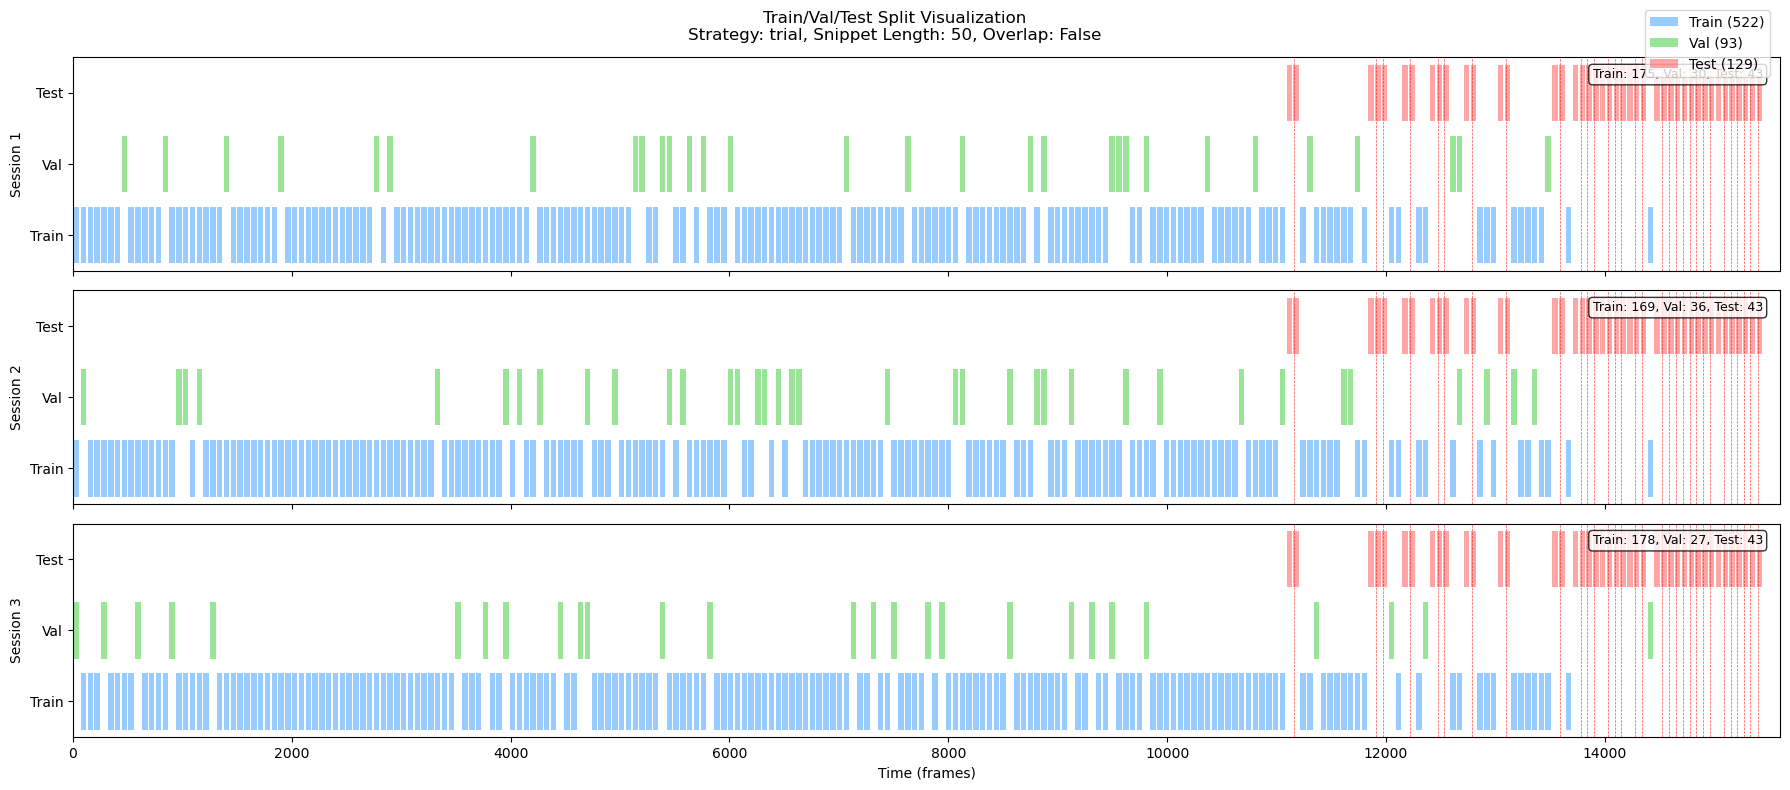


=== Overlap Analysis ===
Session 0: Train frames: 8750, Test frames: 2150, Overlap: 0 frames (0.0% of test)
Session 1: Train frames: 8450, Test frames: 2150, Overlap: 0 frames (0.0% of test)
Session 2: Train frames: 8900, Test frames: 2150, Overlap: 0 frames (0.0% of test)


In [75]:
fig, axes = plt.subplots(3, 1, figsize=(18, 8), sharex=True)

# Get the max time across all sessions for x-axis limits
max_time = max(dfof[s].shape[0] for s in range(3))

# Colors with transparency for overlap visualization
colors = {
    'train': (0.2, 0.6, 1.0, 0.5),    # Blue, semi-transparent
    'val': (0.2, 0.8, 0.2, 0.5),      # Green, semi-transparent  
    'test': (1.0, 0.3, 0.3, 0.5),     # Red, semi-transparent
}

for session in range(3):
    ax = axes[session]
    
    # Get snippets for this session from each split
    train_session = train_df[train_df['session'] == session]
    val_session = val_df[val_df['session'] == session]
    test_session = test_df[test_df['session'] == session]
    
    # Plot each snippet as a horizontal bar
    # Stack them vertically: train at y=0, val at y=1, test at y=2
    bar_height = 0.8
    
    # Train snippets (bottom layer)
    for _, row in train_session.iterrows():
        start = row['snippet_start']
        ax.barh(y=0, width=SNIPPET_LENGTH, left=start, height=bar_height, 
                color=colors['train'], edgecolor='none')
    
    # Val snippets (middle layer)
    for _, row in val_session.iterrows():
        start = row['snippet_start']
        ax.barh(y=1, width=SNIPPET_LENGTH, left=start, height=bar_height,
                color=colors['val'], edgecolor='none')
    
    # Test snippets (top layer)
    for _, row in test_session.iterrows():
        start = row['snippet_start']
        ax.barh(y=2, width=SNIPPET_LENGTH, left=start, height=bar_height,
                color=colors['test'], edgecolor='none')
    
    # Mark stim times from holdout trials
    if SPLIT_STRATEGY == 'trial':
        holdout_stim_times = trials_df[(trials_df['session'] == session) & 
                                        (trials_df['trial'].isin(HOLDOUT_TRIALS))]['stim_time'].values
        for st in holdout_stim_times:
            ax.axvline(x=st, color='red', linestyle='--', alpha=0.7, linewidth=0.5)
    
    ax.set_ylabel(f'Session {session + 1}')
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['Train', 'Val', 'Test'])
    ax.set_xlim(0, max_time)
    ax.set_ylim(-0.5, 2.5)
    
    # Add counts
    ax.text(0.99, 0.95, f'Train: {len(train_session)}, Val: {len(val_session)}, Test: {len(test_session)}',
            transform=ax.transAxes, ha='right', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[2].set_xlabel('Time (frames)')
fig.suptitle(f'Train/Val/Test Split Visualization\n'
             f'Strategy: {SPLIT_STRATEGY}, Snippet Length: {SNIPPET_LENGTH}, Overlap: {SNIPPET_OVERLAP}',
             fontsize=12)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors['train'], label=f'Train ({len(train_df)})'),
                   Patch(facecolor=colors['val'], label=f'Val ({len(val_df)})'),
                   Patch(facecolor=colors['test'], label=f'Test ({len(test_df)})')]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.99, 0.99))

plt.tight_layout()
plt.savefig(f'{new_dir_path}/split_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

# Print overlap analysis
print("\n=== Overlap Analysis ===")
for session in range(3):
    train_times = set()
    test_times = set()
    
    train_session = train_df[train_df['session'] == session]
    test_session = test_df[test_df['session'] == session]
    
    for _, row in train_session.iterrows():
        train_times.update(range(row['snippet_start'], row['snippet_start'] + SNIPPET_LENGTH))
    for _, row in test_session.iterrows():
        test_times.update(range(row['snippet_start'], row['snippet_start'] + SNIPPET_LENGTH))
    
    overlap = train_times & test_times
    print(f"Session {session}: Train frames: {len(train_times)}, Test frames: {len(test_times)}, "
          f"Overlap: {len(overlap)} frames ({100*len(overlap)/max(len(test_times),1):.1f}% of test)")

In [76]:
from tqdm.notebook import tqdm
import time
import torch.nn.functional as F

use_amp = True

# --- training loop with epoch timing and progress bars ---
best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}
scaler = torch.amp.GradScaler("mps" ,enabled=use_amp)
epoch_pbar = tqdm(range(1, NUM_EPOCHS + 1), desc='Epochs', unit='ep')
for epoch in epoch_pbar:
    t0 = time.perf_counter()

    model.train()
    running_loss = 0.0
    for (inputs, activity_initial), targets in tqdm(train_loader, desc=f'Epoch {epoch} Train', leave=False, unit='batch'):
        inputs = inputs.to(device)
        activity_initial = activity_initial.to(device)
        targets = targets.to(device)
        OPTIMIZER.zero_grad(set_to_none=True)
        with torch.autocast(device_type=device_type, dtype=torch.float16, enabled=use_amp):
           outputs = model((inputs, activity_initial))
           # Use weighted loss if available, else standard loss
           if LOSS_TYPE == 'weighted_mae':
               loss = criterion(outputs, targets, inputs)
           else:
               loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(OPTIMIZER)
        scaler.update()
        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(train_loss)
    logging.info(f"Epoch {epoch} Train loss: {train_loss}")

    model.eval()
    val_running = 0.0
    with torch.no_grad(), torch.autocast(
        device_type=device_type,
        dtype=torch.float16,
        enabled=use_amp):
        for (inputs, activity_initial), targets in tqdm(val_loader, desc=f'Epoch {epoch} Val', leave=False, unit='batch'):
            inputs = inputs.to(device)
            activity_initial = activity_initial.to(device)
            targets = targets.to(device)
            outputs = model((inputs, activity_initial))
            # Use weighted loss if available, else standard loss
            if LOSS_TYPE == 'weighted_mae':
                val_loss = criterion(outputs, targets, inputs)
            else:
                val_loss = criterion(outputs, targets)
            val_running += val_loss.item() * inputs.size(0)

    val_loss = val_running / len(val_loader.dataset)
    history['val_loss'].append(val_loss)
    logging.info(f'Epoch {epoch} Validation loss: {val_loss}')


    # stop if no improvement for 5 epochs
    if epoch > 5 and all(history['val_loss'][-i] >= history['val_loss'][-i-1] for i in range(1,6)):
        logging.info ("Early stopping due to no improvement in validation loss for 5 consecutive epochs.")
        break


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_filepath)
        logging.info (f'  Saved best model with val loss {best_val_loss:.6f} to {checkpoint_filepath}')



    epoch_time = time.perf_counter() - t0
    epoch_pbar.set_postfix({'train': f'{train_loss:.6f}', 'val': f'{val_loss:.6f}', 'sec': f'{epoch_time:.2f}'})


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-07 17:38:29,215 INFO: Epoch 1 Train loss: 0.022755266834492884


Epoch 1 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-07 17:38:29,444 INFO: Epoch 1 Validation loss: 0.027111819975318446
2026-01-07 17:38:29,450 INFO:   Saved best model with val loss 0.027112 to rnn_training/20260107_145843/best_model.pth


Epoch 2 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:38:34,573 INFO: Epoch 2 Train loss: 0.021140276818354238


Epoch 2 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:38:34,885 INFO: Epoch 2 Validation loss: 0.022941028879534815
2026-01-07 17:38:34,890 INFO:   Saved best model with val loss 0.022941 to rnn_training/20260107_145843/best_model.pth


Epoch 3 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:38:40,465 INFO: Epoch 3 Train loss: 0.015707555983458212


Epoch 3 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:38:40,782 INFO: Epoch 3 Validation loss: 0.016254987162087235
2026-01-07 17:38:40,787 INFO:   Saved best model with val loss 0.016255 to rnn_training/20260107_145843/best_model.pth


Epoch 4 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:38:45,813 INFO: Epoch 4 Train loss: 0.013963667145962345


Epoch 4 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:38:46,017 INFO: Epoch 4 Validation loss: 0.015437733649867036
2026-01-07 17:38:46,021 INFO:   Saved best model with val loss 0.015438 to rnn_training/20260107_145843/best_model.pth


Epoch 5 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:38:50,920 INFO: Epoch 5 Train loss: 0.013668199365965708


Epoch 5 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:38:51,125 INFO: Epoch 5 Validation loss: 0.014453007929748105
2026-01-07 17:38:51,129 INFO:   Saved best model with val loss 0.014453 to rnn_training/20260107_145843/best_model.pth


Epoch 6 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:38:56,165 INFO: Epoch 6 Train loss: 0.012941154783370394


Epoch 6 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:38:56,370 INFO: Epoch 6 Validation loss: 0.014487993112334641


Epoch 7 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:39:01,498 INFO: Epoch 7 Train loss: 0.012947898122599754


Epoch 7 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:39:01,700 INFO: Epoch 7 Validation loss: 0.013896465364102554
2026-01-07 17:39:01,704 INFO:   Saved best model with val loss 0.013896 to rnn_training/20260107_145843/best_model.pth


Epoch 8 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:39:06,559 INFO: Epoch 8 Train loss: 0.012506924136060065


Epoch 8 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:39:06,759 INFO: Epoch 8 Validation loss: 0.014959371869041714


Epoch 9 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:39:11,511 INFO: Epoch 9 Train loss: 0.012406932693188903


Epoch 9 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:39:11,860 INFO: Epoch 9 Validation loss: 0.013983148185195781


Epoch 10 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:39:16,654 INFO: Epoch 10 Train loss: 0.012441752792489482


Epoch 10 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:39:16,953 INFO: Epoch 10 Validation loss: 0.013555326093468935
2026-01-07 17:39:16,957 INFO:   Saved best model with val loss 0.013555 to rnn_training/20260107_145843/best_model.pth


Epoch 11 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:39:21,824 INFO: Epoch 11 Train loss: 0.012214504685467002


Epoch 11 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:39:22,126 INFO: Epoch 11 Validation loss: 0.013908195043964091


Epoch 12 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:39:26,930 INFO: Epoch 12 Train loss: 0.01192278628704991


Epoch 12 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:39:27,137 INFO: Epoch 12 Validation loss: 0.013960913795056522


Epoch 13 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:39:32,441 INFO: Epoch 13 Train loss: 0.011587957944364156


Epoch 13 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:39:32,789 INFO: Epoch 13 Validation loss: 0.012780789896765704
2026-01-07 17:39:32,793 INFO:   Saved best model with val loss 0.012781 to rnn_training/20260107_145843/best_model.pth


Epoch 14 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:39:37,744 INFO: Epoch 14 Train loss: 0.010780223973552158


Epoch 14 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:39:38,049 INFO: Epoch 14 Validation loss: 0.01177421812048202
2026-01-07 17:39:38,054 INFO:   Saved best model with val loss 0.011774 to rnn_training/20260107_145843/best_model.pth


Epoch 15 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:39:43,240 INFO: Epoch 15 Train loss: 0.010295130697817638


Epoch 15 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:39:43,579 INFO: Epoch 15 Validation loss: 0.011894733624993473


Epoch 16 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:39:50,302 INFO: Epoch 16 Train loss: 0.009903352720113435


Epoch 16 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:39:50,568 INFO: Epoch 16 Validation loss: 0.010905590894762226
2026-01-07 17:39:50,573 INFO:   Saved best model with val loss 0.010906 to rnn_training/20260107_145843/best_model.pth


Epoch 17 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:39:55,953 INFO: Epoch 17 Train loss: 0.009549286177246279


Epoch 17 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:39:56,341 INFO: Epoch 17 Validation loss: 0.011363167586105486


Epoch 18 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:40:02,224 INFO: Epoch 18 Train loss: 0.009615244484824126


Epoch 18 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:40:02,573 INFO: Epoch 18 Validation loss: 0.010520615925391516
2026-01-07 17:40:02,577 INFO:   Saved best model with val loss 0.010521 to rnn_training/20260107_145843/best_model.pth


Epoch 19 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:40:08,000 INFO: Epoch 19 Train loss: 0.009536547632709546


Epoch 19 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:40:08,313 INFO: Epoch 19 Validation loss: 0.010709360732586794


Epoch 20 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:40:13,702 INFO: Epoch 20 Train loss: 0.009670027974150876


Epoch 20 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:40:14,067 INFO: Epoch 20 Validation loss: 0.011245676166107577


Epoch 21 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:40:20,612 INFO: Epoch 21 Train loss: 0.009430940286167165


Epoch 21 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:40:20,847 INFO: Epoch 21 Validation loss: 0.010816247372697759


Epoch 22 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:40:27,555 INFO: Epoch 22 Train loss: 0.009453504885122237


Epoch 22 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:40:27,803 INFO: Epoch 22 Validation loss: 0.011154230003074934


Epoch 23 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:40:33,945 INFO: Epoch 23 Train loss: 0.009401402816219234


Epoch 23 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:40:34,188 INFO: Epoch 23 Validation loss: 0.011354058980941772


Epoch 24 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:40:39,699 INFO: Epoch 24 Train loss: 0.009431827087240772


Epoch 24 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:40:39,929 INFO: Epoch 24 Validation loss: 0.010996149857879006


Epoch 25 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:40:45,163 INFO: Epoch 25 Train loss: 0.009286934450996676


Epoch 25 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:40:45,400 INFO: Epoch 25 Validation loss: 0.011689313016431306


Epoch 26 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:40:50,496 INFO: Epoch 26 Train loss: 0.009271281287859113


Epoch 26 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:40:50,730 INFO: Epoch 26 Validation loss: 0.011172809507898104


Epoch 27 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:40:56,112 INFO: Epoch 27 Train loss: 0.009363564569859897


Epoch 27 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:40:56,345 INFO: Epoch 27 Validation loss: 0.010842957038192018


Epoch 28 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:41:01,757 INFO: Epoch 28 Train loss: 0.009130874821752082


Epoch 28 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:41:01,977 INFO: Epoch 28 Validation loss: 0.01086921461166874


Epoch 29 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:41:07,149 INFO: Epoch 29 Train loss: 0.009234148236455474


Epoch 29 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:41:07,387 INFO: Epoch 29 Validation loss: 0.010420067826666499
2026-01-07 17:41:07,393 INFO:   Saved best model with val loss 0.010420 to rnn_training/20260107_145843/best_model.pth


Epoch 30 Train:   0%|          | 0/131 [00:00<?, ?batch/s]

2026-01-07 17:41:12,441 INFO: Epoch 30 Train loss: 0.009055972984239059


Epoch 30 Val:   0%|          | 0/24 [00:00<?, ?batch/s]

2026-01-07 17:41:12,669 INFO: Epoch 30 Validation loss: 0.010658103161521496


## Calculate test-error

In [77]:

model = RNNModel(input_size=input_size, units=N_UNITS, output_size=output_size, 
                 num_layers=NUM_LAYERS, initial_cond_size=initial_cond_size)
model.load_state_dict(torch.load(checkpoint_filepath, map_location=device))
model.to(device)
model.eval()
test_running = 0.0
with torch.no_grad():
    for (inputs, activity_initial), targets in tqdm(test_loader, desc='Test', unit='batch'):
        inputs = inputs.to(device)
        activity_initial = activity_initial.to(device)
        targets = targets.to(device)
        outputs = model((inputs, activity_initial))
        # Use weighted loss if available, else standard loss
        if LOSS_TYPE == 'weighted_mae':
            loss = criterion(outputs, targets, inputs)
        else:
            loss = criterion(outputs, targets)
        test_running += loss.item() * inputs.size(0)

test_loss = test_running / len(test_loader.dataset)
logging.info(f'Test Loss: {test_loss:.6f}')

Test:   0%|          | 0/33 [00:00<?, ?batch/s]

2026-01-07 17:48:10,093 INFO: Test Loss: 0.011119


In [78]:
model = RNNModel(input_size=input_size, units=N_UNITS, output_size=output_size, 
                 num_layers=NUM_LAYERS, initial_cond_size=initial_cond_size)
model.load_state_dict(torch.load(checkpoint_filepath, map_location=device))
model.to(device)
model.eval()
test_running = 0.0

plot_inputs = []
plot_outputs = []
plot_targets = []
with torch.no_grad():
    for (inputs, activity_initial), targets in tqdm(test_loader, desc='Test', unit='batch'):
        inputs = inputs.to(device)
        activity_initial = activity_initial.to(device)
        targets = targets.to(device)
        outputs = model((inputs, activity_initial))
        plot_inputs.append(inputs.cpu().numpy())
        plot_outputs.append(outputs.cpu().numpy()) # n batches
        plot_targets.append(targets.cpu().numpy())
plot_inputs = np.concatenate(plot_inputs, axis=0)
plot_outputs = np.concatenate(plot_outputs, axis=0)
plot_targets = np.concatenate(plot_targets, axis=0)

print ("Inputs shape: ", plot_inputs.shape)
print ("Predictions shape: ", plot_outputs.shape)
print ("Targets shape: ", plot_targets.shape)

Test:   0%|          | 0/33 [00:00<?, ?batch/s]

Inputs shape:  (129, 50, 10)
Predictions shape:  (129, 50, 26)
Targets shape:  (129, 50, 26)


## Save correlation of predicted vs real for each time series in test data

In [79]:
# Create mapping from neuron number to output index (model output only has TARGET_NEURONS)
neuron_to_output_idx = {n: i for i, n in enumerate(TARGET_NEURONS)}

os.makedirs(os.path.join(f'rnn_training/{DATETIME_STAMP}/test_sample_corr/'), exist_ok=True)
plt.figure(figsize=(10, 5))

# Track correlations for logging - use dict to accumulate per ROI across all good_pairs instances
all_correlations = []
correlations_by_roi = {}  # roi -> list of correlations

# Only plot neurons that are in TARGET_NEURONS
for config, roi in good_pairs:
    # Skip if this neuron is not in TARGET_NEURONS
    if roi not in TARGET_NEURONS:
        print(f"Skipping ROI {roi} (not in TARGET_NEURONS={TARGET_NEURONS})")
        continue
    
    # Initialize list for this ROI if not already present
    if roi not in correlations_by_roi:
        correlations_by_roi[roi] = []
    
    output_idx = neuron_to_output_idx[roi]
    print(f"Plotting ROI {roi} (config {config}, output index {output_idx}) prediction over test samples")
    
    # randomly choose 10 samples for each pair in good pairs
    for test_sample in np.random.choice(np.arange(plot_targets.shape[0]), min(10, plot_targets.shape[0]), replace=False):
        plt.figure(figsize=(10, 5))
        input = plot_inputs[test_sample, :, :].squeeze()
        stim_times = np.nonzero(input)[0]
        electrodes = np.nonzero(input)[1]
        for i, time in enumerate(stim_times):
            current = input[stim_times[i], electrodes[i]]
            if current == 3:
                plt.axvline(x=time, color='r', linestyle='--')
            elif current == 4:
                plt.axvline(x=time, color='b', linestyle='--')
            elif current == 5:
                plt.axvline(x=time, color='g', linestyle='--')
            else:
                pass
        plt.title(f"ROI {roi}, test sample {test_sample}")
        ax = plt.gca()
        corr_value = np.corrcoef(plot_outputs[test_sample, :, output_idx],
                                 plot_targets[test_sample, :, output_idx])[0, 1]
        all_correlations.append(corr_value)
        correlations_by_roi[roi].append(corr_value)
        ax.text(0.98, 0.98, f"corr={corr_value:.3f}", transform=ax.transAxes,
                ha='right', va='top')

        plt.plot(plot_outputs[test_sample, :, output_idx], 'blue', linewidth=1.0, label="predicted")
        plt.plot(plot_targets[test_sample, :, output_idx], 'orange', linewidth=1.0, label="ground truth")
        plt.ylim(-0.5, 1.0)
        plt.yticks([-0.5, 0, 0.5, 1.0])
        plt.grid()
        plt.legend()
        plt.savefig(os.path.join(f'rnn_training/{DATETIME_STAMP}/test_sample_corr', f"{roi}_{config}_{test_sample}.png"))
        plt.close()

# Log average correlation for each unique ROI (accumulated across all good_pairs instances)
for roi, corrs in correlations_by_roi.items():
    roi_avg_corr = np.nanmean(corrs)
    logging.info(f"ROI {roi}: avg correlation = {roi_avg_corr:.4f} (n={len(corrs)} samples across all good_pairs)")

# Log overall average correlation
overall_avg_corr = np.nanmean(all_correlations)
logging.info(f"Overall avg correlation across all good pairs: {overall_avg_corr:.4f} (n={len(all_correlations)} samples)")

Plotting ROI 26 (config 3, output index 23) prediction over test samples
Plotting ROI 22 (config 3, output index 13) prediction over test samples
Plotting ROI 31 (config 7, output index 25) prediction over test samples
Plotting ROI 26 (config 8, output index 23) prediction over test samples
Plotting ROI 31 (config 8, output index 25) prediction over test samples
Plotting ROI 26 (config 9, output index 23) prediction over test samples
Plotting ROI 27 (config 9, output index 24) prediction over test samples
Plotting ROI 31 (config 9, output index 25) prediction over test samples
Plotting ROI 26 (config 11, output index 23) prediction over test samples
Plotting ROI 26 (config 12, output index 23) prediction over test samples
Plotting ROI 22 (config 13, output index 13) prediction over test samples
Plotting ROI 22 (config 14, output index 13) prediction over test samples
Plotting ROI 23 (config 14, output index 14) prediction over test samples
Plotting ROI 22 (config 15, output index 13) p

<Figure size 1000x500 with 0 Axes>

# Random overlay of timeseries for each roy overlaid

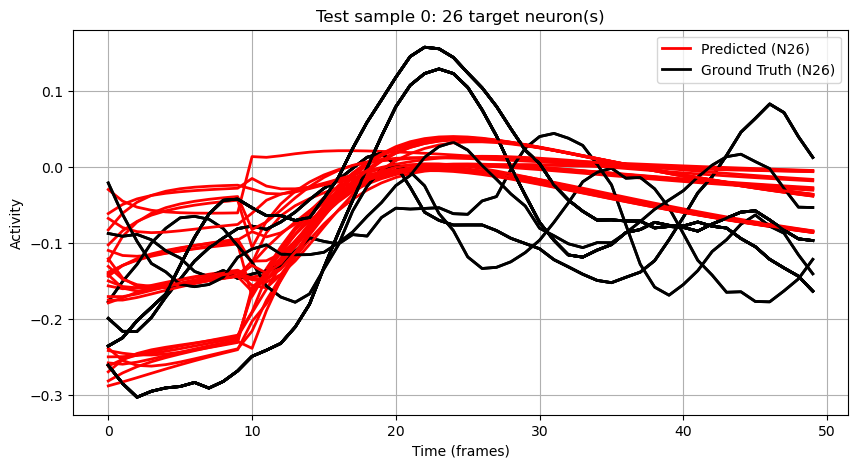

In [80]:
# Random overlay of timeseries for each target neuron overlaid
plt.figure(figsize=(10, 5))
n_target_neurons = plot_outputs.shape[2]  # Number of TARGET_NEURONS
for i, neuron in enumerate(TARGET_NEURONS):
    plt.plot(plot_outputs[0, :, i], 'r', linewidth=2.0, label=f'Predicted (N{neuron})' if i == 0 else '')
    plt.plot(plot_targets[0, :, i], 'k', linewidth=2.0, label=f'Ground Truth (N{neuron})' if i == 0 else '')
plt.xlabel('Time (frames)')
plt.ylabel('Activity')
plt.title(f'Test sample 0: {len(TARGET_NEURONS)} target neuron(s)')
plt.legend()
plt.grid(True)

## Loss over Epochs Plot

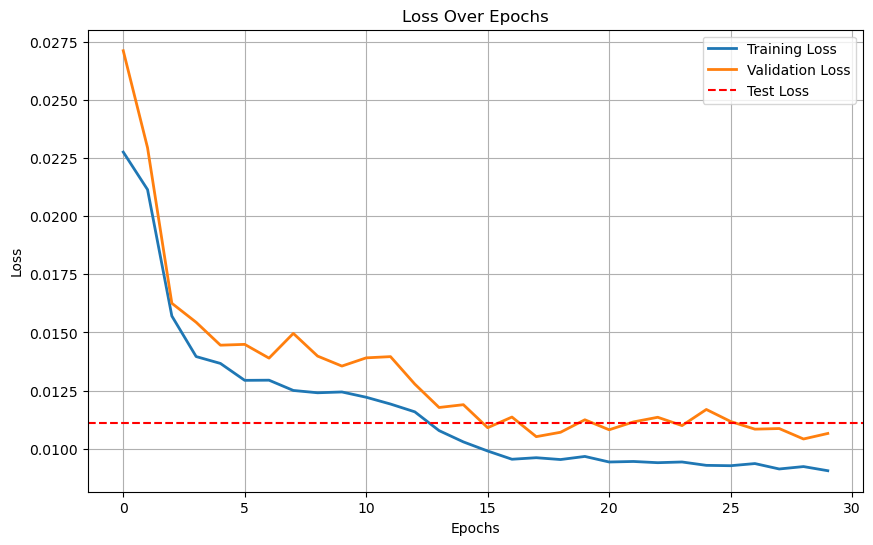

In [81]:
# ----- Plot training, validation, and test loss -----
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss', linewidth=2.0)
plt.plot(history['val_loss'], label='Validation Loss', linewidth=2.0)
plt.axhline(y=test_loss, color='r', linestyle='--', linewidth=1.5, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'{new_dir_path}/loss_over_epochs.png')
plt.show()

## PSTHs like Yuxuans


In [88]:
# PSTHs like Yuxuans
# For each config, choose neurons of interest and plot PSTHs neurons on rows, session on columns 
# use test_df DataFrame as reference 

import json
import matplotlib.cm as cm

# Load neurons of interest from JSON config file
with open('psth_neurons_config.json', 'r') as f:
    psth_config = json.load(f)

neurons_by_config = psth_config['neurons_by_config']
default_neurons = psth_config['default_neurons']

# OFFSET: time within snippet when stim should occur (0 = stim at start, 10 = see 10 frames before stim)
STIM_OFFSET = 0 # frames before stim to show in plot
POST_STIM_FRAMES = 50  # frames after stim to show for ground truth

# Option: use all data (with session columns) or just test data
USE_ALL_DATA = True  # If True, plot all data with 3 session columns; if False, use only test data

# Alpha settings: low for train, high for test
TRAIN_ALPHA = 0.3
TEST_ALPHA = 0.9

model = RNNModel(input_size=input_size, units=N_UNITS, output_size=output_size, 
                 num_layers=NUM_LAYERS, initial_cond_size=initial_cond_size)
model.load_state_dict(torch.load(checkpoint_filepath, map_location=device))
model.to(device)
model.eval()

# Create psths directory if it doesn't exist
os.makedirs(f'rnn_training/{DATETIME_STAMP}/psths', exist_ok=True)

# Get train indices for checking if a sample is in training set
train_indices = set(train_df.index)
test_indices = set(test_df.index)

# Create neuron index mapping: original neuron number -> index in filtered dfof
# If FILTER_NEURONS is None, identity mapping; otherwise map to filtered indices
if FILTER_NEURONS is not None:
    neuron_to_dfof_idx = {n: i for i, n in enumerate(FILTER_NEURONS)}
else:
    neuron_to_dfof_idx = {n: n - 1 for n in range(1, dfof[0].shape[1] + 1)}  # 1-indexed to 0-indexed

# Create mapping for model output: neuron number -> index in TARGET_NEURONS
# Model output only has TARGET_NEURONS columns
neuron_to_output_idx = {n: i for i, n in enumerate(TARGET_NEURONS)}

# Choose which DataFrame to use
if USE_ALL_DATA:
    # Use valid_df which contains all valid snippets
    source_df = valid_df
    n_sessions = 3
else:
    source_df = test_df
    n_sessions = 1

# Total frames to display: STIM_OFFSET before + POST_STIM_FRAMES after
TOTAL_DISPLAY_FRAMES = STIM_OFFSET + POST_STIM_FRAMES

# Determine which configs to iterate over
if FILTER_CONFIGS is not None:
    configs_to_plot = FILTER_CONFIGS
else:
    configs_to_plot = list(range(1, 32))

for config in configs_to_plot:
    # Get neurons of interest for this config from JSON, fall back to default if empty
    neurons_of_interest = neurons_by_config.get(str(config), default_neurons)
    if len(neurons_of_interest) == 0:
        neurons_of_interest = default_neurons
    
    # Only plot neurons that are in TARGET_NEURONS (since model only predicts those)
    neurons_of_interest = [n for n in neurons_of_interest if n in TARGET_NEURONS]
    if len(neurons_of_interest) == 0:
        # Fall back to all target neurons if none from config match
        neurons_of_interest = TARGET_NEURONS
    
    # Filter for snippets where stim occurs at the OFFSET time for this config
    matching_df = source_df[(source_df['first_config'] == config) & (source_df['first_stim_time'] == STIM_OFFSET)]
    
    logging.info(f'Config {config} has {len(matching_df)} matching snippets (stim at t={STIM_OFFSET}), neurons: {neurons_of_interest}')
    if len(matching_df) == 0:
        logging.info(f'No matching snippets for config {config} with stim at offset {STIM_OFFSET}, skipping.')
        continue
    
    # Create figure: rows = neurons, columns = sessions (if USE_ALL_DATA) or 1 column
    # Square subplots
    subplot_size = 4  # inches per subplot (square)
    if USE_ALL_DATA:
        f, ax = plt.subplots(len(neurons_of_interest), n_sessions, 
                             figsize=(subplot_size*n_sessions, subplot_size*len(neurons_of_interest)), 
                             sharex=True, sharey=True, squeeze=False)
    else:
        f, ax = plt.subplots(len(neurons_of_interest), 1, 
                             figsize=(subplot_size, subplot_size*len(neurons_of_interest)), 
                             sharex=True, sharey=True, squeeze=False)
    
    # Time axis for prediction (limited by SNIPPET_LENGTH)
    pred_time_axis = np.arange(SNIPPET_LENGTH) - STIM_OFFSET
    
    # Time axis for ground truth (full 60 frames after stim)
    gt_time_axis = np.arange(TOTAL_DISPLAY_FRAMES) - STIM_OFFSET
    
    # Color mapping for current levels (for stim lines)
    current_colors = {3: 'red', 4: 'blue', 5: 'green'}
    
    # plot predictions for the config and neurons of interest
    for row_idx, neuron in enumerate(neurons_of_interest):
        # Get the index in the dfof array (for ground truth)
        dfof_idx = neuron_to_dfof_idx[neuron]
        # Get the index in the model output (for predictions)
        output_idx = neuron_to_output_idx[neuron]
        
        for col_idx in range(n_sessions):
            if USE_ALL_DATA:
                # Filter by session
                session_df = matching_df[matching_df['session'] == col_idx]
                current_ax = ax[row_idx, col_idx]
            else:
                session_df = matching_df
                current_ax = ax[row_idx, 0]
            
            stim_lines_added = {3: False, 4: False, 5: False}  # Track which current labels added
            num_trials = len(session_df)
            
            # Generate distinct colors for each trial using a colormap
            # Use tab10 or tab20 for distinct colors
            trial_cmap = cm.get_cmap('tab10') if num_trials <= 10 else cm.get_cmap('tab20')
            
            for trial_idx, (idx, row) in enumerate(session_df.iterrows()):
                # Determine if this is a training or test sample
                is_train = idx in train_indices
                is_test = idx in test_indices
                
                # Set alpha based on train/test status
                alpha = TRAIN_ALPHA if is_train else TEST_ALPHA
                
                # Get distinct color for this trial (same for GT and prediction)
                trial_color = trial_cmap(trial_idx % trial_cmap.N)
                
                # Determine line style: dashed for prediction, solid for ground truth
                gt_linestyle = '-'
                pred_linestyle = '--'
                
                # Get extended ground truth from raw dfof data
                session = row['session']
                snippet_start = row['snippet_start']
                gt_end = min(snippet_start + TOTAL_DISPLAY_FRAMES, dfof[session].shape[0])
                gt_length = gt_end - snippet_start
                extended_gt = dfof[session][snippet_start:gt_end, dfof_idx]  # Use dfof index
                extended_gt_time = np.arange(gt_length) - STIM_OFFSET
                
                # Create label with train/test indicator
                trial_label = f'Trial {trial_idx+1}' + (' (train)' if is_train else ' (test)')
                
                # Plot ground truth (solid line)
                current_ax.plot(extended_gt_time, extended_gt, alpha=alpha, color=trial_color, 
                               linestyle=gt_linestyle, linewidth=1.5,
                               label=f'{trial_label} GT' if trial_idx == 0 else '') 
                
                # Get prediction (limited by SNIPPET_LENGTH)
                stim_input = np.expand_dims(row['stim_snippet'].astype(np.float32), axis=0)
                activity_input = np.expand_dims(row['initial_condition'].astype(np.float32), axis=0)
                stim_input_t = torch.from_numpy(stim_input).to(device)
                activity_input_t = torch.from_numpy(activity_input).to(device)
                with torch.no_grad():
                    outputs = model((stim_input_t, activity_input_t))
                roi_activity = outputs[0, :, output_idx].cpu().numpy()  # Use output index
                
                # Plot prediction (dashed line, same color)
                current_ax.plot(pred_time_axis, roi_activity, alpha=alpha, color=trial_color,
                               linestyle=pred_linestyle, linewidth=1.5,
                               label=f'{trial_label} Pred' if trial_idx == 0 else '')
                
                # Add dashed vertical lines at stimulation times (relative to STIM_OFFSET)
                stim_snippet = row['stim_snippet']
                stim_times_idx = np.nonzero(stim_snippet)[0]
                electrodes_idx = np.nonzero(stim_snippet)[1]
                for t_idx, e_idx in zip(stim_times_idx, electrodes_idx):
                    current = int(stim_snippet[t_idx, e_idx])
                    color = current_colors.get(current, 'gray')
                    label = f'Stim (I={current})' if not stim_lines_added[current] else ''
                    current_ax.axvline(x=stim_times_idx, color=color, linestyle=':', alpha=0.7, label=label)
                    stim_lines_added[current] = True
            
            # Set fixed y-limits and x-limits
            current_ax.set_ylim(-0.5, 1.0)
            current_ax.set_xlim(-STIM_OFFSET, POST_STIM_FRAMES)
            
            # Set specific tick marks
            current_ax.set_yticks([-0.5, 0, 0.5, 1.0])
            current_ax.set_xticks([-STIM_OFFSET, 0, 50])
            
            # Make subplot square by setting aspect ratio
            current_ax.set_aspect('auto')
            
            if USE_ALL_DATA:
                current_ax.set_title(f'Config {config}, Neuron {neuron}, Session {col_idx + 1}')
            else:
                current_ax.set_title(f'Config {config}, Neuron {neuron}')
            current_ax.set_xlabel('Time relative to snippet start (frames)')
            current_ax.set_ylabel('Activity')
            
            # Add a simple legend explaining line styles
            if num_trials > 0 and row_idx == 0 and col_idx == 0:
                from matplotlib.lines import Line2D
                legend_elements = [
                    Line2D([0], [0], color='gray', linestyle='-', label='Ground Truth'),
                    Line2D([0], [0], color='gray', linestyle='--', label='Predicted'),
                    Line2D([0], [0], color='gray', linestyle='-', alpha=TEST_ALPHA, linewidth=2, label='Test (high α)'),
                    Line2D([0], [0], color='gray', linestyle='-', alpha=TRAIN_ALPHA, linewidth=2, label='Train (low α)'),
                ]
                current_ax.legend(handles=legend_elements, loc='upper right', fontsize='small')
    
    plt.tight_layout()
    plt.savefig(f'{new_dir_path}/psths/config_{config}.png')
    plt.close()

2026-01-07 17:54:52,137 INFO: Config 1 has 24 matching snippets (stim at t=10), neurons: [22, 26]


/var/folders/38/_qz39whn0hngmtsmjg9byfbr0000gn/T/ipykernel_64608/4254220704.py:132: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  trial_cmap = cm.get_cmap('tab10') if num_trials <= 10 else cm.get_cmap('tab20')


2026-01-07 17:54:52,994 INFO: Config 2 has 24 matching snippets (stim at t=10), neurons: [22, 26]
2026-01-07 17:54:53,531 INFO: Config 3 has 24 matching snippets (stim at t=10), neurons: [22, 26]
2026-01-07 17:54:54,083 INFO: Config 4 has 24 matching snippets (stim at t=10), neurons: [26, 22, 31, 26, 31, 26, 27, 31, 26, 26, 22, 22, 23, 22, 23, 21, 21, 31, 31, 26, 31, 26, 31, 26, 27, 31]
2026-01-07 17:55:03,996 INFO: Config 5 has 24 matching snippets (stim at t=10), neurons: [26, 22, 31, 26, 31, 26, 27, 31, 26, 26, 22, 22, 23, 22, 23, 21, 21, 31, 31, 26, 31, 26, 31, 26, 27, 31]
2026-01-07 17:55:13,601 INFO: Config 6 has 24 matching snippets (stim at t=10), neurons: [26, 22, 31, 26, 31, 26, 27, 31, 26, 26, 22, 22, 23, 22, 23, 21, 21, 31, 31, 26, 31, 26, 31, 26, 27, 31]
2026-01-07 17:55:23,187 INFO: Config 7 has 24 matching snippets (stim at t=10), neurons: [26, 27, 31]
2026-01-07 17:55:24,001 INFO: Config 8 has 24 matching snippets (stim at t=10), neurons: [26, 27, 31]
2026-01-07 17:55:2

Saved to rnn_training/20260107_145843/rasters/n31_c28_t0.1.png


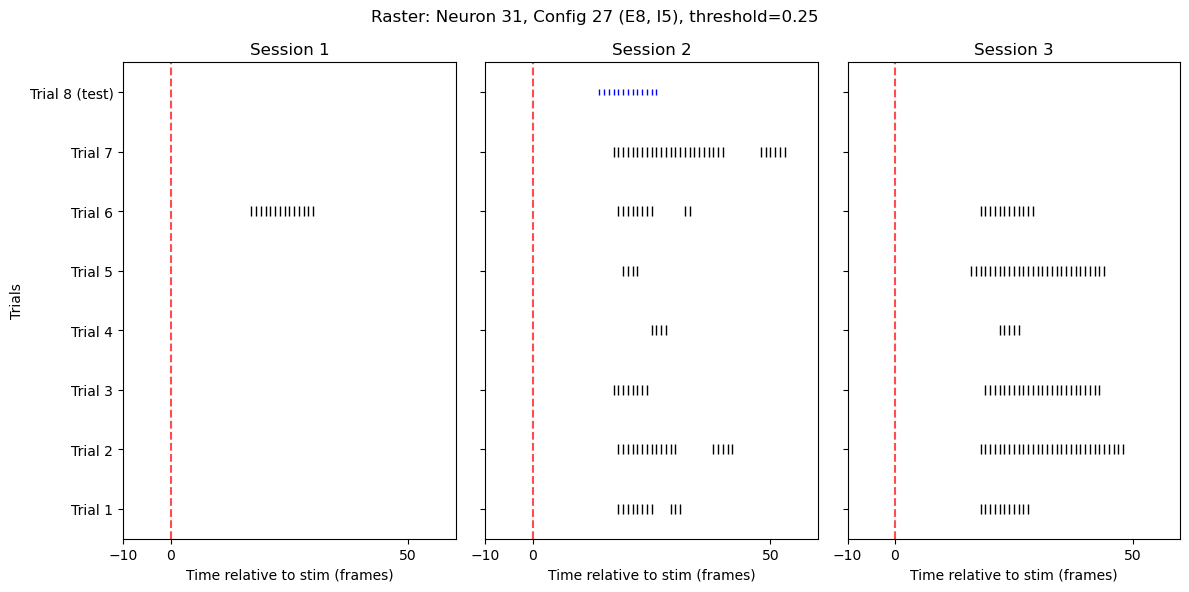

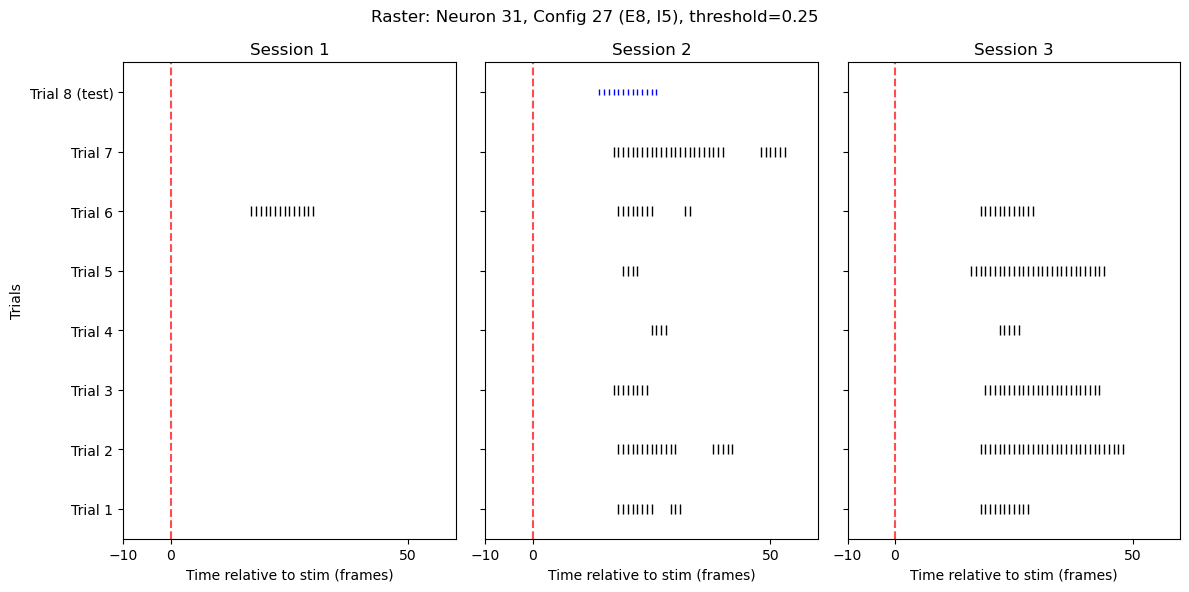

In [83]:
def plot_stim_raster(neuron, config, threshold=0.3, pre_stim_frames=10, post_stim_frames=60, 
                     sessions=None, save_path=None):
    """
    Plot a raster of threshold-crossing events for a given neuron and config.
    
    Parameters
    ----------
    neuron : int
        Neuron index (1-indexed, MATLAB style)
    config : int
        Config number (1-31)
    threshold : float
        Activity threshold for marking events (default 0.3)
    pre_stim_frames : int
        Frames before stim to show (default 10)
    post_stim_frames : int
        Frames after stim to show (default 60)
    sessions : list or None
        Which sessions to include (0-indexed). If None, uses all 3.
    save_path : str or None
        If provided, saves figure to this path
    """
    if sessions is None:
        sessions = [0, 1, 2]
    
    # Get all trials for this config
    config_trials = trials_df[trials_df['config'] == config]
    
    # Calculate electrode and current from config
    if config <= 30:
        electrode = (config - 1) // 3
        current = (config - 1) % 3 + 3
    else:
        electrode = -1
        current = 0
    
    # Create figure: one column per session
    n_sessions = len(sessions)
    fig, axes = plt.subplots(1, n_sessions, figsize=(4*n_sessions, 6), sharey=True, squeeze=False)
    axes = axes[0]  # Flatten to 1D
    
    # Time axis relative to stim
    time_axis = np.arange(-pre_stim_frames, post_stim_frames)
    
    for ax_idx, session in enumerate(sessions):
        ax = axes[ax_idx]
        session_trials = config_trials[config_trials['session'] == session].sort_values('trial')
        
        y_offset = 0  # Track vertical position for each trial
        trial_labels = []
        
        for _, trial_row in session_trials.iterrows():
            trial_num = trial_row['trial']
            start_time = trial_row['start_time']
            
            # Get activity window around start time
            start_idx = max(0, start_time - pre_stim_frames)
            end_idx = min(dfof[session].shape[0], start_time + post_stim_frames)
            
            # Get activity for this neuron (neuron-1 for 0-indexing)
            activity = dfof[session][start_idx:end_idx, neuron - 1]
            
            # Adjust time axis based on actual data available
            actual_pre = start_time - start_idx
            actual_time = np.arange(-actual_pre, len(activity) - actual_pre)
            
            # Find threshold crossings
            above_threshold = activity > threshold
            crossing_times = actual_time[above_threshold]
            
            # Determine if this is a test trial (from HOLDOUT_TRIALS)
            is_test = trial_num in HOLDOUT_TRIALS
            marker = '|' if is_test else '|'  # Square for test, line for train
            color = 'blue' if is_test else 'black'
            
            # Plot raster ticks for this trial
            if len(crossing_times) > 0:
                ax.scatter(crossing_times, np.full_like(crossing_times, y_offset, dtype=float), 
                          marker=marker, s=20 if is_test else 50, color=color, linewidths=1)
            
            trial_labels.append(f'Trial {trial_num + 1}' + (' (test)' if is_test else ''))
            y_offset += 1
        
        # Add stim time marker
        ax.axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5, label='Stim time')
        
        # Formatting
        ax.set_xlim(-pre_stim_frames, post_stim_frames)
        ax.set_ylim(-0.5, len(session_trials) - 0.5)
        ax.set_yticks(range(len(session_trials)))
        ax.set_yticklabels(trial_labels)
        ax.set_xlabel('Time relative to stim (frames)')
        ax.set_title(f'Session {session + 1}')
        ax.set_xticks([-pre_stim_frames, 0, 50])
        
        if ax_idx == 0:
            ax.set_ylabel('Trials')
    
    # Add overall title
    fig.suptitle(f'Raster: Neuron {neuron}, Config {config} (E{electrode}, I{current}), threshold={threshold}', 
                 fontsize=12)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f'Saved to {save_path}')
    
    # plt.show()
    return fig

# Example usage:
# plot_stim_raster(neuron=31, config=27, threshold=0.1)
if not os.path.exists(os.path.join(new_dir_path, "rasters")):
    os.makedirs(os.path.join(new_dir_path, "rasters"))
plot_stim_raster(neuron=31, config=27, threshold=0.25, save_path=os.path.join(new_dir_path, "rasters", "n31_c28_t0.1.png"))

In [84]:
# Generate rasters for all good_pairs at multiple thresholds
# good_pairs format: (config, neuron)
thresholds = [0.1, 0.2, 0.3]

# Create rasters directory
rasters_dir = os.path.join(new_dir_path, "rasters")
os.makedirs(rasters_dir, exist_ok=True)

for config, neuron in good_pairs:
    for thresh in thresholds:
        save_name = f"raster_c{config}_n{neuron}_t{thresh}.png"
        save_path = os.path.join(rasters_dir, save_name)
        print(f"Generating: Config {config}, Neuron {neuron}, Threshold {thresh}")
        plot_stim_raster(neuron=neuron, config=config, threshold=thresh, save_path=save_path)
        plt.close()

print(f"\nSaved {len(good_pairs) * len(thresholds)} raster plots to {rasters_dir}")

Generating: Config 3, Neuron 26, Threshold 0.1
Saved to rnn_training/20260107_145843/rasters/raster_c3_n26_t0.1.png
Generating: Config 3, Neuron 26, Threshold 0.2
Saved to rnn_training/20260107_145843/rasters/raster_c3_n26_t0.2.png
Generating: Config 3, Neuron 26, Threshold 0.3
Saved to rnn_training/20260107_145843/rasters/raster_c3_n26_t0.3.png
Generating: Config 3, Neuron 22, Threshold 0.1
Saved to rnn_training/20260107_145843/rasters/raster_c3_n22_t0.1.png
Generating: Config 3, Neuron 22, Threshold 0.2
Saved to rnn_training/20260107_145843/rasters/raster_c3_n22_t0.2.png
Generating: Config 3, Neuron 22, Threshold 0.3
Saved to rnn_training/20260107_145843/rasters/raster_c3_n22_t0.3.png
Generating: Config 7, Neuron 31, Threshold 0.1
Saved to rnn_training/20260107_145843/rasters/raster_c7_n31_t0.1.png
Generating: Config 7, Neuron 31, Threshold 0.2
Saved to rnn_training/20260107_145843/rasters/raster_c7_n31_t0.2.png
Generating: Config 7, Neuron 31, Threshold 0.3
Saved to rnn_training/202

Config 1: Electrode 0, Current 3
Config 2: Electrode 0, Current 4
Config 3: Electrode 0, Current 5
Config 4: Electrode 1, Current 3
Config 5: Electrode 1, Current 4
Config 6: Electrode 1, Current 5
Config 7: Electrode 2, Current 3
Config 8: Electrode 2, Current 4
Config 9: Electrode 2, Current 5
Config 10: Electrode 3, Current 3
Config 11: Electrode 3, Current 4
Config 12: Electrode 3, Current 5
Config 13: Electrode 4, Current 3
Config 14: Electrode 4, Current 4
Config 15: Electrode 4, Current 5
Config 16: Electrode 5, Current 3
Config 17: Electrode 5, Current 4
Config 18: Electrode 5, Current 5
Config 19: Electrode 6, Current 3
Config 20: Electrode 6, Current 4
Config 21: Electrode 6, Current 5
Config 22: Electrode 7, Current 3
Config 23: Electrode 7, Current 4
Config 24: Electrode 7, Current 5
Config 25: Electrode 8, Current 3
Config 26: Electrode 8, Current 4
Config 27: Electrode 8, Current 5
Config 28: Electrode 9, Current 3
Config 29: Electrode 9, Current 4
Config 30: Electrode 9,

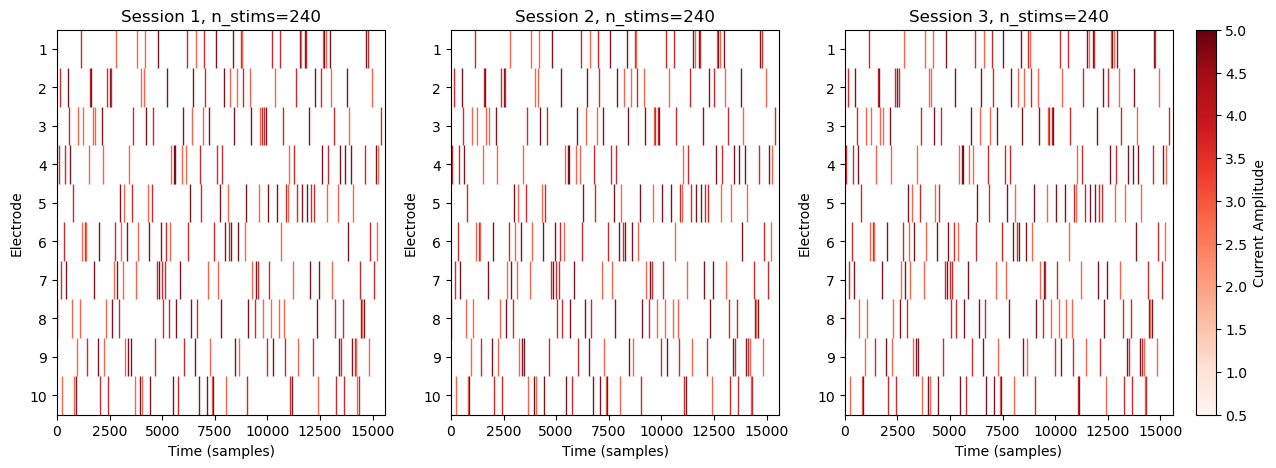

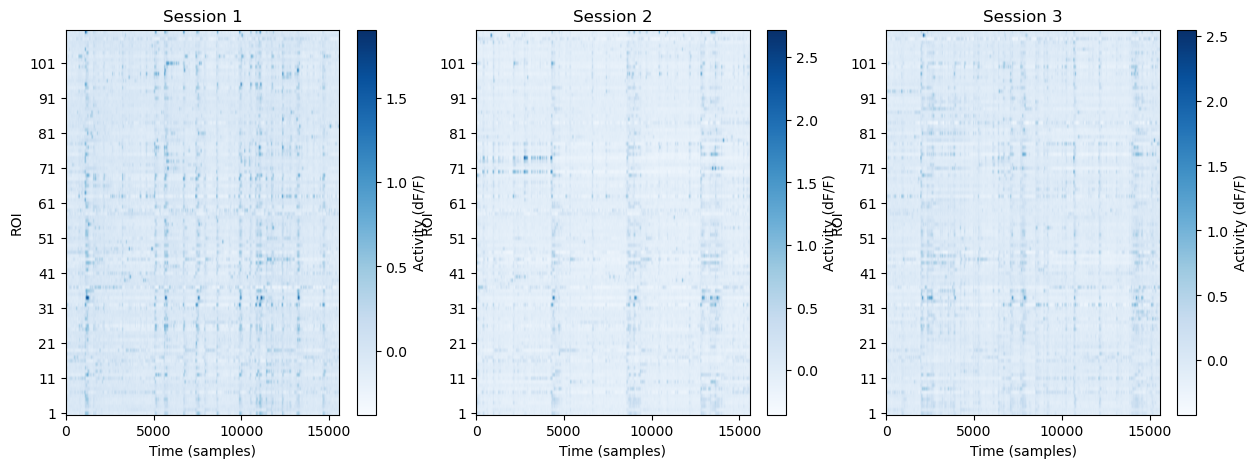

In [85]:
stim_times_sess = []
for session in range(3):
    stim_times = np.zeros((dfof[session].shape[0], 10))
    for config in range(1, 31): # last config is no stim
        electrode = (config-1) // 3
        current = (config-1)%3 + 3
        print(f'Config {config}: Electrode {electrode}, Current {current}')
        for i in range(8):
            config_time = times[session][i,config-1]
            stim_times[config_time, electrode] = current
    stim_times_sess.append(stim_times) # len 3, each (n_times, n_electrodes)

stim_times_sess = np.array(stim_times_sess)
print ("Stim times sess shape: ", stim_times_sess.shape)

# how many frames have no stimulation?
n_no_stim = [stim_times_sess[i].shape[0] - np.count_nonzero(stim_times_sess[i]) for i in range(3)]
print (f'Number of no-stim frames per session: {",".join([str(n) for n in n_no_stim])} assuming 1 ms current pulse')




plot_stim_ticks(stim_times_sess, session_ids=None, tick_width=6, cmap_name='Reds',
                figsize=(15, 5), out_path=f'rnn_training/{DATETIME_STAMP}/stim_times_sessions_ticks.png',
                invert_y=True)

plot_activity_per_session(dfof, session_ids=None,
                          figsize=(15,5),
                          out_path=f'rnn_training/{DATETIME_STAMP}/activity_sessions.png')

Confusion scope: 72 stim-at-t0 snippets, 3600 frames | splits: test | threshold=P90 | configs=[3, 7, 8, 9, 11, 12, 13, 14, 15, 23, 24, 26, 27, 28, 29, 30]
2026-01-07 18:00:31,598 INFO: Confusion scope: 72 stim-at-t0 snippets, 3600 frames | splits: test | threshold=P90 | configs=[3, 7, 8, 9, 11, 12, 13, 14, 15, 23, 24, 26, 27, 28, 29, 30]
2026-01-07 18:00:31,598 INFO: Confusion matrix source size (stim-at-t0 only): 72 | configs=[3, 7, 8, 9, 11, 12, 13, 14, 15, 23, 24, 26, 27, 28, 29, 30] | include_train=False | include_val=False
2026-01-07 18:00:31,612 INFO: Computed SPIKE_THRESHOLD at P90 for 6 neurons
2026-01-07 18:00:32,093 INFO: Neuron 26: accuracy=0.884, precision=0.715, recall=0.518 | TP=314, TN=2869, FP=125, FN=292 | frames=3600
2026-01-07 18:00:32,093 INFO: Neuron 22: accuracy=0.858, precision=0.507, recall=0.265 | TP=137, TN=2950, FP=133, FN=380 | frames=3600
2026-01-07 18:00:32,093 INFO: Neuron 31: accuracy=0.884, precision=0.662, recall=0.515 | TP=288, TN=2894, FP=147, FN=271

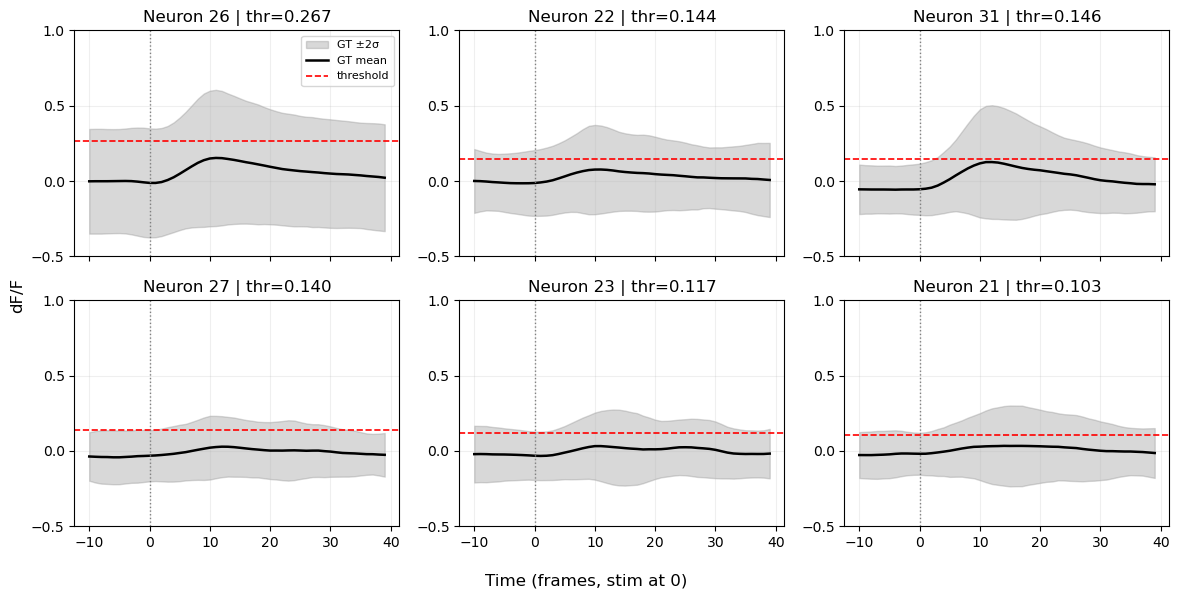

2026-01-07 18:00:32,309 INFO: Confusion analysis complete.


In [91]:
# --- Confusion matrix of spike detection per neuron ---
# Computes binary spikes from ground truth and model predictions using a percentile threshold.
# Supports filtering by configs and selecting test-only vs train+test snippets.

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
THRESH_PERCENTILE = 90            # Percentile to set SPIKE_THRESHOLD per neuron
CONF_CONFIGS = None               # e.g., [27, 28] or None for all configs
INCLUDE_TRAIN = False             # False = test-only; True = train + test
INCLUDE_VAL = False               # Optional: include validation as well
GOOD_CONFIGS = sorted({c for c, _ in good_pairs})  # configs with known good responses

# Build source DataFrame
dfs = [test_df]
if INCLUDE_TRAIN:
    dfs.append(train_df)
if INCLUDE_VAL:
    dfs.append(val_df)
source_df = pd.concat(dfs, axis=0)

effective_configs = CONF_CONFIGS if (CONF_CONFIGS is not None and len(CONF_CONFIGS) > 0) else GOOD_CONFIGS
source_df = source_df[source_df['first_config'].isin(effective_configs)]

# Restrict to stim-at-t0 snippets only (one per stim trial)
if STIM_DELAY == 0:
    source_df = source_df[(source_df['has_stim']) & (source_df['stim_at_t0'])]
else:
    source_df = source_df[(source_df['has_stim']) & (source_df['first_stim_time'] == STIM_DELAY)]
num_trials = len(source_df)
total_frames = num_trials * SNIPPET_LENGTH
split_desc = f"test{' + train' if INCLUDE_TRAIN else ''}{' + val' if INCLUDE_VAL else ''}"
scope_msg = (
    f"Confusion scope: {num_trials} stim-at-t0 snippets, {total_frames} frames | "
    f"splits: {split_desc} | threshold=P{THRESH_PERCENTILE} | configs={effective_configs}"
)
print(scope_msg)
logging.info(scope_msg)
logging.info(
    f"Confusion matrix source size (stim-at-t0 only): {len(source_df)} | "
    f"configs={effective_configs} | include_train={INCLUDE_TRAIN} | include_val={INCLUDE_VAL}"
)

# Mapping from neuron number to dfof index (ground truth) and output index (model predictions)
if FILTER_NEURONS is not None:
    neuron_to_dfof_idx = {n: i for i, n in enumerate(FILTER_NEURONS)}
else:
    neuron_to_dfof_idx = {n: n - 1 for n in range(1, dfof[0].shape[1] + 1)}

# Preserve order but ensure uniqueness for plotting
unique_neurons = list(dict.fromkeys(TARGET_NEURONS))

neuron_to_output_idx = {n: i for i, n in enumerate(TARGET_NEURONS)}

# Ensure model is loaded and in eval mode (reload to be safe)
model = RNNModel(input_size=input_size, units=N_UNITS, output_size=output_size, 
                 num_layers=NUM_LAYERS, initial_cond_size=initial_cond_size)
model.load_state_dict(torch.load(checkpoint_filepath, map_location=device))
model.to(device)
model.eval()

# Compute SPIKE_THRESHOLD per neuron using THRESH_PERCENTILE over all sessions/timepoints
SPIKE_THRESHOLD = {}
for neuron in unique_neurons:
    d_idx = neuron_to_dfof_idx[neuron]
    all_vals = np.concatenate([dfof[s][:, d_idx] for s in range(dfof.shape[0])], axis=0)
    SPIKE_THRESHOLD[neuron] = np.nanpercentile(all_vals, THRESH_PERCENTILE)

logging.info(f"Computed SPIKE_THRESHOLD at P{THRESH_PERCENTILE} for {len(unique_neurons)} neurons")

# Initialize confusion counts and trace accumulation per neuron
conf_counts = {n: {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0} for n in unique_neurons}
trace_accum = {n: [] for n in unique_neurons}

# Iterate over selected snippets and accumulate confusion entries per frame
with torch.no_grad():
    for idx, row in source_df.iterrows():
        session = row['session']
        start = row['snippet_start']
        end = start + SNIPPET_LENGTH
        gt_window = dfof[session][start:end, :]
        
        stim_input = np.expand_dims(row['stim_snippet'].astype(np.float32), axis=0)
        init_cond = np.expand_dims(row['initial_condition'].astype(np.float32), axis=0)
        stim_t = torch.from_numpy(stim_input).to(device)
        init_t = torch.from_numpy(init_cond).to(device)
        
        outputs = model((stim_t, init_t))
        pred_np = outputs[0].cpu().numpy()
        
        for neuron in unique_neurons:
            d_idx = neuron_to_dfof_idx[neuron]
            o_idx = neuron_to_output_idx[neuron]
            thr = SPIKE_THRESHOLD[neuron]
            
            gt_binary = (gt_window[:, d_idx] > thr).astype(np.uint8)
            pred_binary = (pred_np[:, o_idx] > thr).astype(np.uint8)
            
            TP = np.sum((pred_binary == 1) & (gt_binary == 1))
            TN = np.sum((pred_binary == 0) & (gt_binary == 0))
            FP = np.sum((pred_binary == 1) & (gt_binary == 0))
            FN = np.sum((pred_binary == 0) & (gt_binary == 1))
            
            conf_counts[neuron]['TP'] += int(TP)
            conf_counts[neuron]['TN'] += int(TN)
            conf_counts[neuron]['FP'] += int(FP)
            conf_counts[neuron]['FN'] += int(FN)
            trace_accum[neuron].append(gt_window[:, d_idx])

# Compute and log metrics per neuron
for neuron, c in conf_counts.items():
    total = c['TP'] + c['TN'] + c['FP'] + c['FN']
    acc = (c['TP'] + c['TN']) / total if total > 0 else float('nan')
    prec = c['TP'] / (c['TP'] + c['FP']) if (c['TP'] + c['FP']) > 0 else float('nan')
    rec = c['TP'] / (c['TP'] + c['FN']) if (c['TP'] + c['FN']) > 0 else float('nan')
    logging.info(
        f"Neuron {neuron}: accuracy={acc:.3f}, precision={prec:.3f}, recall={rec:.3f} | "
        f"TP={c['TP']}, TN={c['TN']}, FP={c['FP']}, FN={c['FN']} | frames={total}"
    )

# Overall summary accuracy across all neurons/frames
total_TP = sum(c['TP'] for c in conf_counts.values())
total_TN = sum(c['TN'] for c in conf_counts.values())
total_FP = sum(c['FP'] for c in conf_counts.values())
total_FN = sum(c['FN'] for c in conf_counts.values())
overall_total = total_TP + total_TN + total_FP + total_FN
overall_acc = (total_TP + total_TN) / overall_total if overall_total > 0 else float('nan')

print(f"Overall spike-detection accuracy: {overall_acc:.3f} | TP={total_TP}, TN={total_TN}, FP={total_FP}, FN={total_FN}, frames={overall_total}")
logging.info(f"Overall spike-detection accuracy: {overall_acc:.3f} | TP={total_TP}, TN={total_TN}, FP={total_FP}, FN={total_FN}, frames={overall_total}")

# Plot mean ground-truth trace per neuron with 2 std bands and threshold
# Time axis centered on stim: stim occurs at frame (START_OFFSET + STIM_DELAY) within snippet
time_axis = np.arange(SNIPPET_LENGTH) - (START_OFFSET + STIM_DELAY)
n_neurons = len(unique_neurons)
cols = int(np.ceil(np.sqrt(n_neurons))) if n_neurons > 0 else 1
rows = int(np.ceil(n_neurons / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True)
axes = np.atleast_1d(axes).reshape(rows, cols)

y_min, y_max = -0.5, 1.0
y_ticks = np.arange(y_min, y_max + 0.01, 0.5)

for ax, neuron in zip(axes.flat, unique_neurons):
    traces = trace_accum.get(neuron, [])
    if len(traces) > 0:
        stacked = np.stack(traces, axis=0)
        mean_trace = np.mean(stacked, axis=0)
        std_trace = np.std(stacked, axis=0)
        upper = mean_trace + 2 * std_trace
        lower = mean_trace - 2 * std_trace
        ax.fill_between(time_axis, lower, upper, color='gray', alpha=0.3, label='GT ±2σ')
        ax.plot(time_axis, mean_trace, color='black', lw=1.8, label='GT mean')
        ax.axhline(SPIKE_THRESHOLD[neuron], color='red', linestyle='--', lw=1.2, label='threshold')
        ax.set_title(f"Neuron {neuron} | thr={SPIKE_THRESHOLD[neuron]:.3f}")
    else:
        ax.text(0.5, 0.5, 'no data', ha='center', va='center', fontsize=10)
    ax.axvline(0, color='gray', linestyle=':', lw=1)
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(y_ticks)
    ax.grid(alpha=0.2)

# Hide unused axes
for ax in axes.flat[n_neurons:]:
    ax.set_visible(False)

# Add legend to first axis with data
for ax in axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(loc='upper right', fontsize=8)
        break

fig.supxlabel('Time (frames, stim at 0)')
fig.supylabel('dF/F')
fig.tight_layout()
plt.show()

logging.info("Confusion analysis complete.")

In [110]:
def blue_to_red_8():
    cmap = cm.get_cmap("RdBu_r")
    # Avoid the central white region (~0.45–0.55)
    vals = np.concatenate([
        np.linspace(0.2, 0.40, 4),
        np.linspace(0.6, 0.8, 4)
    ])[::-1]   # <-- flip order
    return cmap(vals)


In [111]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import logging
import torch

# --- settings ---
LINE_ALPHA = 0.9
GT_LW = 2.0
PRED_LW = 1.2



# Ensure we always have all snippets (so we can mix train/test/val in same plot)
source_df = valid_df
n_sessions = 3

TOTAL_DISPLAY_FRAMES = STIM_OFFSET + POST_STIM_FRAMES
pred_time_axis = np.arange(SNIPPET_LENGTH) - STIM_OFFSET

current_colors = {3: 'red', 4: 'blue', 5: 'green'}

for config in configs_to_plot:
    neurons_of_interest = neurons_by_config.get(str(config), default_neurons) or default_neurons
    neurons_of_interest = [n for n in neurons_of_interest if n in TARGET_NEURONS] or TARGET_NEURONS

    matching_df = source_df[
        (source_df["first_config"] == config) &
        (source_df["first_stim_time"] == STIM_DELAY)
    ]

    logging.info(
        f"Config {config} has {len(matching_df)} matching snippets (stim at t={STIM_DELAY}), "
        f"neurons: {neurons_of_interest}"
    )
    if len(matching_df) == 0:
        continue

    # --- figure: rows=neurons, cols=3 sessions ---
    subplot_size = 4
    f, ax = plt.subplots(
        len(neurons_of_interest), n_sessions,
        figsize=(subplot_size * n_sessions, subplot_size * len(neurons_of_interest)),
        sharex=True, sharey=True, squeeze=False
    )

    for row_idx, neuron in enumerate(neurons_of_interest):
        dfof_idx = neuron_to_dfof_idx[neuron]
        output_idx = neuron_to_output_idx[neuron]

        for col_idx in range(n_sessions):
            current_ax = ax[row_idx, col_idx]

            # session subset
            session_df = matching_df[matching_df["session"] == col_idx]

            # Pick up to 8 trials deterministically (by index order)
            session_df = session_df.sort_index().head(MAX_TRIALS_PER_SESSION)

            stim_lines_added = {3: False, 4: False, 5: False}

            for trial_num, (idx, row) in enumerate(session_df.iterrows(), start=1):
                # trial_num is 1..8
                trial_color = trial_colors_8[trial_num - 1]

                # linestyle encodes split: train dashed, test/val solid
                is_train_or_val = idx not in test_indices 
                split_ls = "--" if is_train_or_val else "-"

                # --- Ground truth ---
                session = row["session"]
                snippet_start = row["snippet_start"]
                gt_end = min(snippet_start + TOTAL_DISPLAY_FRAMES, dfof[session].shape[0])
                gt_length = gt_end - snippet_start
                extended_gt = dfof[session][snippet_start:gt_end, dfof_idx]
                extended_gt_time = np.arange(gt_length) - STIM_OFFSET

                current_ax.plot(
                    extended_gt_time, extended_gt,
                    color=trial_color, alpha=LINE_ALPHA,
                    linestyle=split_ls, linewidth=GT_LW,
                    label=f"Trial {trial_num} GT" if trial_num == 1 else None
                )

                # --- Prediction ---
                stim_input = np.expand_dims(row["stim_snippet"].astype(np.float32), axis=0)
                activity_input = np.expand_dims(row["initial_condition"].astype(np.float32), axis=0)
                stim_input_t = torch.from_numpy(stim_input).to(device)
                activity_input_t = torch.from_numpy(activity_input).to(device)

                with torch.no_grad():
                    outputs = model((stim_input_t, activity_input_t))
                roi_activity = outputs[0, :, output_idx].detach().cpu().numpy()

                current_ax.plot(
                    pred_time_axis, roi_activity,
                    color=trial_color, alpha=LINE_ALPHA,
                    linestyle=split_ls, linewidth=PRED_LW,
                    label=f"Trial {trial_num} Pred" if trial_num == 1 else None
                )

                # --- stimulation vertical lines (keep as before) ---
                stim_snippet = row["stim_snippet"]
                stim_times_idx = np.nonzero(stim_snippet)[0]
                electrodes_idx = np.nonzero(stim_snippet)[1]
                for t_idx, e_idx in zip(stim_times_idx, electrodes_idx):
                    current = int(stim_snippet[t_idx, e_idx])
                    vcol = current_colors.get(current, "gray")
                    vlab = f"Stim (I={current})" if (current in stim_lines_added and not stim_lines_added[current]) else None
                    current_ax.axvline(
                        x=t_idx - STIM_OFFSET, color=vcol, linestyle=":", alpha=0.7, label=vlab
                    )
                    if current in stim_lines_added:
                        stim_lines_added[current] = True

            # axes formatting
            current_ax.set_ylim(-0.5, 1.0)
            current_ax.set_xlim(-STIM_OFFSET, POST_STIM_FRAMES)
            current_ax.set_yticks([-0.5, 0, 0.5, 1.0])
            current_ax.set_xticks([-STIM_OFFSET, 0, 50])
            current_ax.set_aspect("auto")

            current_ax.set_title(f"Config {config}, ROI {neuron}, Session {col_idx + 1}")
            current_ax.set_xlabel("Time (frames)")
            current_ax.set_ylabel("Activity")

            # One legend for the whole figure (only once, top-left panel)
            if row_idx == 0 and col_idx == 0:
                legend_elements = [
                    Line2D([0], [0], color="gray", linestyle="-", linewidth=1.5, label="Test (solid)"),
                    Line2D([0], [0], color="gray", linestyle="--", linewidth=1.5, label="Train/Val (dashed)"),
                    Line2D([0], [0], color="gray", linestyle="-", linewidth=GT_LW, label="Ground Truth (thick)"),
                    Line2D([0], [0], color="gray", linestyle="-", linewidth=PRED_LW, label="Predicted (thin)"),
                ]
                current_ax.legend(handles=legend_elements, loc="upper right", fontsize="small")

    plt.tight_layout()
    outpath = os.path.join(psth_dir, f"config_{config}_a.png")
    plt.savefig(outpath, dpi=200)
    plt.close(f)
    logging.info(f"Saved combined PSTH: {outpath}")


2026-01-07 20:37:14,160 INFO: Config 1 has 24 matching snippets (stim at t=10), neurons: [22, 26]
2026-01-07 20:37:14,830 INFO: Saved combined PSTH: rnn_training/20260107_145843/psths/config_1_a.png
2026-01-07 20:37:14,831 INFO: Config 2 has 24 matching snippets (stim at t=10), neurons: [22, 26]
2026-01-07 20:37:15,648 INFO: Saved combined PSTH: rnn_training/20260107_145843/psths/config_2_a.png
2026-01-07 20:37:15,648 INFO: Config 3 has 24 matching snippets (stim at t=10), neurons: [22, 26]
2026-01-07 20:37:16,271 INFO: Saved combined PSTH: rnn_training/20260107_145843/psths/config_3_a.png
2026-01-07 20:37:16,272 INFO: Config 4 has 24 matching snippets (stim at t=10), neurons: [26, 22, 31, 26, 31, 26, 27, 31, 26, 26, 22, 22, 23, 22, 23, 21, 21, 31, 31, 26, 31, 26, 31, 26, 27, 31]
2026-01-07 20:37:27,377 INFO: Saved combined PSTH: rnn_training/20260107_145843/psths/config_4_a.png
2026-01-07 20:37:27,380 INFO: Config 5 has 24 matching snippets (stim at t=10), neurons: [26, 22, 31, 26, 31

In [ ]:
trial_colors_8 = blue_to_red_8()

# Ensure we always have all snippets (so we can mix train/test/val in same plot)
source_df = valid_df
n_sessions = 3

TOTAL_DISPLAY_FRAMES = STIM_DELAY + POST_STIM_FRAMES
pred_time_axis = np.arange(SNIPPET_LENGTH) - STIM_DELAY

current_colors = {3: 'red', 4: 'blue', 5: 'green'}

for config in configs_to_plot:
    neurons_of_interest = neurons_by_config.get(str(config), default_neurons)
    if neurons_of_interest is None or len(neurons_of_interest) == 0:
        neurons_of_interest = TARGET_NEURONS
    neurons_of_interest = [n for n in neurons_of_interest if n in TARGET_NEURONS] 

    if config != 31: 
        matching_df = source_df[
            (source_df["first_config"] == config) &
            (source_df["first_stim_time"] == STIM_DELAY)
        ] 
    else: # no stim for 31
        matching_df = source_df[
            (source_df["first_config"] == config)
        ]
    
    logging.info(
        f"Config {config} has {len(matching_df)} matching snippets (stim at t={STIM_DELAY}), "
        f"neurons: {neurons_of_interest}"
    )
    if len(matching_df) == 0:
        continue

    # --- figure: rows=neurons, cols=3 sessions ---
    subplot_size = 2.5  # Reduced from 4 to make the plot smaller
    f, ax = plt.subplots(
        len(neurons_of_interest), n_sessions,
        figsize=(subplot_size * n_sessions, subplot_size * len(neurons_of_interest)),
        sharex=True, sharey=True, squeeze=False
    )

    for row_idx, neuron in enumerate(neurons_of_interest):
        dfof_idx = neuron_to_dfof_idx[neuron]
        output_idx = neuron_to_output_idx[neuron]

        for col_idx in range(n_sessions):
            current_ax = ax[row_idx, col_idx]

            # session subset
            session_df = matching_df[matching_df["session"] == col_idx]
            assert len(session_df) == 8

            stim_lines_added = {3: False, 4: False, 5: False}
            # TODO: MAKE SURE ONLY ONE TEST TRIAL PER SESSION IS PRESENT
            for trial_num, (idx, row) in enumerate(session_df.iterrows(), start=1):
                # trial_num is 1..8
                trial_color = trial_colors_8[trial_num - 1]

                # linestyle encodes split: train dashed, test/val solid
                is_train_or_val = idx not in test_indices 
                split_ls = "--" if is_train_or_val else "-"

                # --- Prediction ---
                stim_input = np.expand_dims(row["stim_snippet"].astype(np.float32), axis=0)
                activity_input = np.expand_dims(row["initial_condition"].astype(np.float32), axis=0)
                stim_input_t = torch.from_numpy(stim_input).to(device)
                activity_input_t = torch.from_numpy(activity_input).to(device)

                with torch.no_grad():
                    outputs = model((stim_input_t, activity_input_t))
                roi_activity = outputs[0, :, output_idx].detach().cpu().numpy()

                current_ax.plot(
                    pred_time_axis, roi_activity,
                    color=trial_color, alpha=LINE_ALPHA,
                    linestyle=split_ls, linewidth=PRED_LW,
                    label=f"Trial {trial_num} Pred" if trial_num == 1 else None
                )

                # --- stimulation vertical lines (keep as before) ---
                stim_snippet = row["stim_snippet"]
                stim_times_idx = np.nonzero(stim_snippet)[0]
                electrodes_idx = np.nonzero(stim_snippet)[1]
                for t_idx, e_idx in zip(stim_times_idx, electrodes_idx):
                    current = int(stim_snippet[t_idx, e_idx])
                    vcol = current_colors.get(current, "gray")
                    vlab = f"Stim (I={current})" if (current in stim_lines_added and not stim_lines_added[current]) else None
                    current_ax.axvline(
                        x=t_idx - STIM_DELAY, color=vcol, linestyle=":", alpha=0.7, label=vlab
                    )
                    if current in stim_lines_added:
                        stim_lines_added[current] = True

            # axes formatting
            current_ax.set_ylim(-0.5, 1.0)
            current_ax.set_yticks([-0.5, 0, 0.5, 1.0])
            # Only label frames 0 and 50 on x axis
            current_ax.set_xticks([0, 50])
            current_ax.set_aspect("auto")

            current_ax.set_title(f"Config {config}, ROI {neuron}, Session {col_idx + 1}")
            current_ax.set_xlabel("Time (frames)")
            current_ax.set_ylabel("Activity")

            # One legend for the whole figure (only once, top-left panel)
            if row_idx == 0 and col_idx == 0:
                legend_elements = [
                    Line2D([0], [0], color="gray", linestyle="-", linewidth=2, label="Test (solid)"),
                    Line2D([0], [0], color="gray", linestyle="--", linewidth=2, label="Train (dashed)"),
                ]
                current_ax.legend(handles=legend_elements, loc="upper right", fontsize="small")

    plt.tight_layout()
    outpath = os.path.join(psth_dir, f"config_{config}_b.png")
    plt.savefig(outpath, dpi=250)
    plt.close(f)
    logging.info(f"Saved combined PSTH: {outpath}")


2026-01-07 21:09:04,196 INFO: Config 1 has 24 matching snippets (stim at t=10), neurons: [22, 26]


/var/folders/38/_qz39whn0hngmtsmjg9byfbr0000gn/T/ipykernel_64608/3572022883.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdBu_r")


2026-01-07 21:09:04,828 INFO: Saved combined PSTH: rnn_training/20260107_145843/psths/config_1_b.png
2026-01-07 21:09:04,829 INFO: Config 2 has 24 matching snippets (stim at t=10), neurons: [22, 26]
2026-01-07 21:09:05,454 INFO: Saved combined PSTH: rnn_training/20260107_145843/psths/config_2_b.png
2026-01-07 21:09:05,455 INFO: Config 3 has 24 matching snippets (stim at t=10), neurons: [22, 26]
2026-01-07 21:09:06,055 INFO: Saved combined PSTH: rnn_training/20260107_145843/psths/config_3_b.png
2026-01-07 21:09:06,055 INFO: Config 4 has 24 matching snippets (stim at t=10), neurons: []


ValueError: Number of rows must be a positive integer, not 0

<Figure size 750x0 with 0 Axes>